In [1]:
!pip install openmeteo-requests
!pip install requests-cache retry-requests numpy pandas

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 167.1/167.1 kB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 684.2/684.2 kB 15.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 145.8/145.8 kB 9.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 394.1/394.1 kB 14.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 54.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.4/61.4 kB 1.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 70.7/70.7 kB 5.0 MB/s eta 0:00:00


# Pull California Weather

In [2]:
import openmeteo_requests

import pandas as pd
import requests_cache
from retry_requests import retry

# --- 1) Fetch hourly weather (Pepperwood, local time) ---
import openmeteo_requests
import pandas as pd
import numpy as np
import requests_cache
from retry_requests import retry

# Pepperwood Preserve (you provided)
LAT, LON = 38.569772741712356, -122.68955306578343
TZ = "America/Los_Angeles"

cache_session = requests_cache.CachedSession('.cache', expire_after=-1)
retry_session = retry(cache_session, retries=5, backoff_factor=0.2)
openmeteo = openmeteo_requests.Client(session=retry_session)

url = "https://archive-api.open-meteo.com/v1/archive"
params = {
    "latitude": LAT,
    "longitude": LON,
    "start_date": "2015-07-01",
    "end_date":   "2015-08-31",
    "hourly": [
        "temperature_2m", "relative_humidity_2m", "dew_point_2m",
        "wind_speed_10m", "wind_speed_100m", "wind_direction_10m", "wind_direction_100m",
        "surface_pressure", "cloud_cover", "cloud_cover_low", "rain", "shortwave_radiation"
    ],
    "timezone": TZ,  # force local time directly from API
}

responses = openmeteo.weather_api(url, params=params)
response = responses[0]

hourly = response.Hourly()
# Build local-time hourly index directly from API-provided start/end (they are UTC seconds; convert then tz-convert)
idx_utc = pd.date_range(
    start=pd.to_datetime(hourly.Time(),    unit="s", utc=True),
    end=  pd.to_datetime(hourly.TimeEnd(), unit="s", utc=True),
    freq=pd.Timedelta(seconds=hourly.Interval()),
    inclusive="left"
)
idx_local = idx_utc.tz_convert(TZ)

weather_df = pd.DataFrame({
    "timestamp": idx_local,
    "temperature_2m":      hourly.Variables(0).ValuesAsNumpy(),
    "relative_humidity_2m":hourly.Variables(1).ValuesAsNumpy(),
    "dew_point_2m":        hourly.Variables(2).ValuesAsNumpy(),
    "wind_speed_10m":      hourly.Variables(3).ValuesAsNumpy(),
    "wind_speed_100m":     hourly.Variables(4).ValuesAsNumpy(),
    "wind_direction_10m":  hourly.Variables(5).ValuesAsNumpy(),
    "wind_direction_100m": hourly.Variables(6).ValuesAsNumpy(),
    "surface_pressure":    hourly.Variables(7).ValuesAsNumpy(),
    "cloud_cover":         hourly.Variables(8).ValuesAsNumpy(),
    "cloud_cover_low":     hourly.Variables(9).ValuesAsNumpy(),
    "rain":                hourly.Variables(10).ValuesAsNumpy(),
    "shortwave_radiation": hourly.Variables(11).ValuesAsNumpy(),
}).sort_values("timestamp").reset_index(drop=True)


In [3]:
weather_df.columns
weather_df.head()

,timestamp,temperature_2m,relative_humidity_2m,dew_point_2m,wind_speed_10m,wind_speed_100m,wind_direction_10m,wind_direction_100m,surface_pressure,cloud_cover,cloud_cover_low,rain,shortwave_radiation
0,2015-07-01 01:00:00-07:00,23.328499,55.709431,13.978500,4.394360,7.145796,235.007904,229.085709,966.831238,8.0,0.0,0.0,0.0
1,2015-07-01 02:00:00-07:00,21.728498,59.239487,13.428500,4.693826,7.421590,237.528824,230.906143,966.704163,54.0,0.0,0.0,0.0
2,2015-07-01 03:00:00-07:00,20.378500,65.628937,13.728500,6.480000,10.446206,270.000000,268.025116,966.514221,49.0,0.0,0.0,0.0
3,2015-07-01 04:00:00-07:00,19.478498,69.843788,13.828500,6.989935,12.313893,281.888641,285.255157,965.716003,43.0,0.0,0.0,0.0
4,2015-07-01 05:00:00-07:00,19.178499,68.658592,13.278501,5.506941,9.000000,281.309906,286.260284,966.247925,66.0,0.0,0.0,0.0


# Merge with California Paper Fog Net Yields

In [4]:
# maunally label MIT-14 fog net data collected at Pepperwood Preserve
# https://dspace.mit.edu/bitstream/handle/1721.1/119788/GHM275.pdf

# first half is collected from 2015-7-30 from 5:45 to 8:45 (PST)
# second half is collected from 2015-8-19 from 4:40 to 11pm (PST)
fog_df = pd.DataFrame({
    "timestamp": pd.to_datetime([
        "2015-07-30 05:45", "2015-07-30 06:00", "2015-07-30 06:15",
        "2015-07-30 06:30", "2015-07-30 06:45", "2015-07-30 07:00",
        "2015-07-30 07:15", "2015-07-30 07:30", "2015-07-30 07:45",
        "2015-07-30 08:00", "2015-07-30 08:15", "2015-07-30 08:30",
        "2015-07-30 08:45",

        "2015-08-19 05:00", "2015-08-19 05:15", "2015-08-19 05:30",
        "2015-08-19 05:45", "2015-08-19 06:00", "2015-08-19 06:15",
        "2015-08-19 06:30", "2015-08-19 06:45", "2015-08-19 07:00",
        "2015-08-19 07:15", "2015-08-19 07:30", "2015-08-19 07:45",
        "2015-08-19 08:00", "2015-08-19 08:15", "2015-08-19 08:30",
        "2015-08-19 08:45", "2015-08-19 09:00", "2015-08-19 09:15",
        "2015-08-19 09:30", "2015-08-19 09:45", "2015-08-19 10:00",
        "2015-08-19 10:15", "2015-08-19 10:30", "2015-08-19 10:45",
        "2015-08-19 11:00",
    ]),
    "fog_yield_15min_L": [
                  0.005, 0.0175, 0.035,
                  0.035, 0.0175, 0.008,
                  0.0175, 0.0175, 0.0175,
                  0.0175, 0, 0,
                  0,

                  0.085, 0.12, 0.07,
                  0.0775, 0.085, 0.06,
                  0.085, 0.07, 0.0925,
                  0.075, 0.075, 0.075,
                  0.045, 0.0525, 0.075,
                  0.07, 0.075, 0.0425,
                  0.0425, 0.035, 0.0175,
                  0.0175, 0.01, 0,
                  0.01
                  ]
})

# localize to Pepperwood local time (these are local times from the paper)
fog_df["timestamp"] = fog_df["timestamp"].dt.tz_localize(TZ)
# ensure 15-min alignment
fog_df["timestamp"] = fog_df["timestamp"].dt.round("15min")

# --- 3) Aggregate fog to hourly with coverage threshold (>=3/4) ---
fog_15 = fog_df.set_index("timestamp").sort_index()

# Sum yield per hour:
fog_hour_sum = fog_15["fog_yield_15min_L"].resample("1H").sum(min_count=1)

# Count how many quarters contributed each hour:
fog_hour_count = fog_15["fog_yield_15min_L"].resample("1H").count()

# Require at least 3 of 4 quarters to accept hour; else NaN
fog_hourly = pd.DataFrame({
    "timestamp": fog_hour_sum.index,
    "fog_yield_L_per_hour": fog_hour_sum.where(fog_hour_count >= 3, np.nan)
}).dropna().reset_index(drop=True)

# --- 4) Build (weather_t -> yield_{t+1}) mapping ---
# Shift labels by -1 hour so each weather row at time t maps to yield at t+1
fog_hourly["target_yield_next_hour"] = fog_hourly["fog_yield_L_per_hour"].shift(-1)

# We only need rows where we have a valid next-hour label
fog_targets = fog_hourly.dropna(subset=["target_yield_next_hour"])[["timestamp", "target_yield_next_hour"]]

# --- 5) Merge weather and labels on exact hourly timestamps ---
# weather_df timestamps are hourly & tz-aware in the same TZ; use exact merge
dataset = pd.merge(
    weather_df.rename(columns={"timestamp":"timestamp"}),
    fog_targets,
    on="timestamp",
    how="inner"
).sort_values("timestamp").reset_index(drop=True)

# --- 6) Feature engineering (wind sin/cos + time cycles) ---
def dir_to_rad(deg):
    # wind direction: 0/360=north, 90=east; convert degrees to radians
    return np.deg2rad(deg % 360)

for h in [10, 100]:
    rad = dir_to_rad(dataset[f"wind_direction_{h}m"])
    dataset[f"wind_dir_{h}m_sin"] = np.sin(rad)
    dataset[f"wind_dir_{h}m_cos"] = np.cos(rad)

# Time-of-day and month as cyclical
dataset["hour"]  = dataset["timestamp"].dt.hour
dataset["month"] = dataset["timestamp"].dt.month

dataset["hour_sin"]  = np.sin(2*np.pi*dataset["hour"]/24)
dataset["hour_cos"]  = np.cos(2*np.pi*dataset["hour"]/24)
dataset["month_sin"] = np.sin(2*np.pi*dataset["month"]/12)
dataset["month_cos"] = np.cos(2*np.pi*dataset["month"]/12)

# Optional: keep only the columns we’ll model with + label
keep_cols = [
    "timestamp",
    "temperature_2m", "relative_humidity_2m", "dew_point_2m",
    "wind_speed_10m", "wind_speed_100m",
    "wind_dir_10m_sin", "wind_dir_10m_cos",
    "wind_dir_100m_sin", "wind_dir_100m_cos",
    "surface_pressure", "cloud_cover", "cloud_cover_low",
    "rain", "shortwave_radiation",
    "hour_sin", "hour_cos", "month_sin", "month_cos",
    "target_yield_next_hour"
]
dataset = dataset[keep_cols].copy()

print("Final aligned dataset (weather_t -> yield_{t+1}):")
print(dataset)

Final aligned dataset (weather_t -> yield_{t+1}):
                  timestamp  temperature_2m  relative_humidity_2m  \
0 2015-07-30 06:00:00-07:00       16.928499             60.475166   
1 2015-07-30 07:00:00-07:00       17.578499             59.222805   
2 2015-07-30 08:00:00-07:00       20.028500             52.023907   
3 2015-08-19 05:00:00-07:00       13.728500             82.374542   
4 2015-08-19 06:00:00-07:00       13.428500             84.557961   
5 2015-08-19 07:00:00-07:00       13.478500             84.844719   
6 2015-08-19 08:00:00-07:00       14.728500             79.027542   
7 2015-08-19 09:00:00-07:00       16.978498             69.126503   

   dew_point_2m  wind_speed_10m  wind_speed_100m  wind_dir_10m_sin  \
0      9.228500        4.510787        10.514218     -8.778965e-01   
1      9.528501        3.671294         6.130579     -9.805807e-01   
2      9.878500        2.520000         2.189795     -8.742278e-08   
3     10.778501        4.024922         7.235910

/tmp/ipython-input-2588958456.py:52: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  fog_hour_sum = fog_15["fog_yield_15min_L"].resample("1H").sum(min_count=1)
/tmp/ipython-input-2588958456.py:55: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  fog_hour_count = fog_15["fog_yield_15min_L"].resample("1H").count()


# install SDV

In [5]:
!pip install sdv sdmetrics --quiet

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sdv.metadata import SingleTableMetadata, Metadata
from sdv.single_table import GaussianCopulaSynthesizer
from sdmetrics.reports.single_table import QualityReport


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 197.0/197.0 kB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 198.3/198.3 kB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.3/139.3 kB 6.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.3/14.3 MB 77.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.7/52.7 kB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 74.3/74.3 kB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 27.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.0/86.0 kB 4.7 MB/s eta 0:00:00


In [6]:
# Drop timestamp and handle missing values
dataset["event_id"] = np.where(dataset["timestamp"].dt.date == pd.Timestamp("2015-08-19").date(),
                               "Aug19", "Jul30")

train_df = dataset.drop(columns=["timestamp"]).dropna().reset_index(drop=True)

print("Training data shape:", train_df.shape)
print(train_df['event_id'].values)

keep = [
    "temperature_2m", "dew_point_2m", "relative_humidity_2m",
    "wind_speed_10m", "cloud_cover_low", "shortwave_radiation",
    "target_yield_next_hour"
]
train_df = train_df[keep]

Training data shape: (8, 20)
['Jul30' 'Jul30' 'Jul30' 'Aug19' 'Aug19' 'Aug19' 'Aug19' 'Aug19']


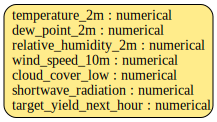

In [7]:
metadata = SingleTableMetadata()
metadata.detect_from_dataframe(train_df)

# You can inspect how SDV interpreted each column:
metadata.visualize()


## Model 1: GaussianCopulaSynthesizer

Training data shape: (8, 20)
Event distribution:
 event_id
Aug19    5
Jul30    3
Name: count, dtype: int64

Training GaussianCopula for Aug19 (5 real → 625 synthetic)...


/usr/local/lib/python3.12/dist-packages/sdv/single_table/base.py:168: FutureWarning: The 'SingleTableMetadata' is deprecated. Please use the new 'Metadata' class for synthesizers.
  warnings.warn(DEPRECATION_MSG, FutureWarning)
/usr/local/lib/python3.12/dist-packages/sdv/single_table/base.py:134: UserWarning: We strongly recommend saving the metadata using 'save_to_json' for replicability in future SDV versions.
  warnings.warn(



Training GaussianCopula for Jul30 (3 real → 375 synthetic)...


/usr/local/lib/python3.12/dist-packages/sdv/single_table/base.py:168: FutureWarning: The 'SingleTableMetadata' is deprecated. Please use the new 'Metadata' class for synthesizers.
  warnings.warn(DEPRECATION_MSG, FutureWarning)


Synthetic combined shape: (1000, 8)


,mean,std
temperature_2m,15.860,2.394
dew_point_2m,10.460,0.791
relative_humidity_2m,71.457,12.987
wind_speed_10m,3.661,0.979
cloud_cover_low,2.125,2.997
shortwave_radiation,82.125,115.396
target_yield_next_hour,0.191,0.134


,mean,std
temperature_2m,16.105,2.114
dew_point_2m,10.487,0.731
relative_humidity_2m,70.410,11.980
wind_speed_10m,3.563,0.914
cloud_cover_low,2.275,2.791
shortwave_radiation,103.510,102.146
target_yield_next_hour,0.191,0.106


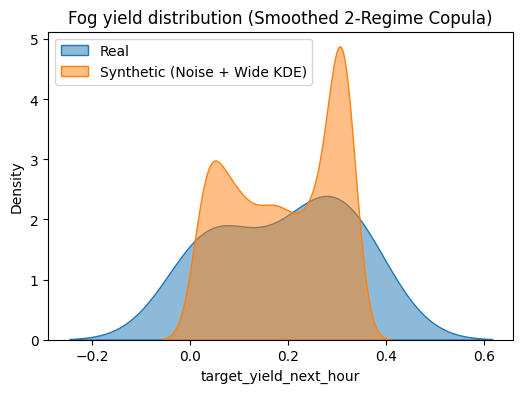

Generating report ...

(1/2) Evaluating Column Shapes: |██████████| 7/7 [00:00<00:00, 261.44it/s]|
Column Shapes Score: 77.17%

(2/2) Evaluating Column Pair Trends: |██████████| 21/21 [00:00<00:00, 90.53it/s]| 
Column Pair Trends Score: 96.28%

Overall Score (Average): 86.72%

GaussianCopula (Smoothed 2-Regime) overall score: 0.867


,Column,Metric,Score
0,temperature_2m,KSComplement,0.750
1,dew_point_2m,KSComplement,0.875
2,relative_humidity_2m,KSComplement,0.853
3,wind_speed_10m,KSComplement,0.783
4,cloud_cover_low,KSComplement,0.648


,Column 1,Column 2,Metric,Score,Real Correlation,Synthetic Correlation
0,temperature_2m,dew_point_2m,CorrelationSimilarity,0.990577,-0.611603,-0.630448
1,temperature_2m,relative_humidity_2m,CorrelationSimilarity,0.999342,-0.973687,-0.975002
2,temperature_2m,wind_speed_10m,CorrelationSimilarity,0.974942,-0.646581,-0.596466
3,temperature_2m,cloud_cover_low,CorrelationSimilarity,0.994243,-0.554065,-0.542551
4,temperature_2m,shortwave_radiation,CorrelationSimilarity,0.975930,0.495159,0.447018


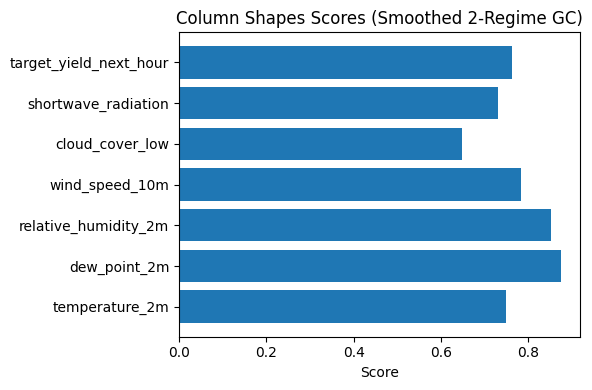

In [8]:
# helper function - SAFE SDV INTERNAL MODEL EXTRACTOR (version-proof)

def get_column_models(synth):
    """
    Safely extract {column_name: model_object} from a GaussianCopulaSynthesizer
    regardless of SDV version.
    """
    candidates = [
        getattr(synth, "model", None),
        getattr(synth, "_model", None),
        getattr(synth, "_fitted_model", None),
        getattr(synth, "column_models", None),
    ]

    for c in candidates:
        if c is None:
            continue

        # Case A: modern SDV (dict)
        if isinstance(c, dict):
            return c

        # Case B: object with .column_models dict
        if hasattr(c, "column_models") and isinstance(c.column_models, dict):
            return c.column_models

        # Case C: object with .columns dict
        if hasattr(c, "columns") and isinstance(c.columns, dict):
            return c.columns

    # Fallback: nothing found
    return {}


# --- 📦 PREPROCESS & EVENT SPLIT ---

dataset["event_id"] = np.where(
    dataset["timestamp"].dt.date == pd.Timestamp("2015-08-19").date(),
    "Aug19", "Jul30"
)

train_df = dataset.drop(columns=["timestamp"]).dropna().reset_index(drop=True)
print("Training data shape:", train_df.shape)
print("Event distribution:\n", train_df["event_id"].value_counts())

keep = [
    "event_id",
    "temperature_2m", "dew_point_2m", "relative_humidity_2m",
    "wind_speed_10m", "cloud_cover_low", "shortwave_radiation",
    "target_yield_next_hour"
]
train_df = train_df[keep].copy()

metadata = SingleTableMetadata()
metadata.detect_from_dataframe(train_df)
metadata.visualize()

# --- 🧠 TRAIN PER-EVENT COPULAS (with noise + balanced weighting) ---
from sdv.single_table import GaussianCopulaSynthesizer
from sdmetrics.reports.single_table import QualityReport
import matplotlib.pyplot as plt, seaborn as sns
from sklearn.isotonic import IsotonicRegression
import numpy as np

synth_dict, synthetic_list = {}, []
weights = train_df["event_id"].value_counts(normalize=True)
total_rows = 1000  # total synthetic sample size

for event, weight in weights.items():
    event_df = train_df[train_df["event_id"] == event].reset_index(drop=True)
    n_samples = int(total_rows * weight)
    print(f"\nTraining GaussianCopula for {event} ({len(event_df)} real → {n_samples} synthetic)...")

    # --- 🔧 Bootstrap noise augmentation ---
    event_df_aug = event_df.copy()
    noise_scale = 0.05  # 5% std noise
    for col in ["temperature_2m", "dew_point_2m", "relative_humidity_2m",
                "wind_speed_10m", "cloud_cover_low", "shortwave_radiation",
                "target_yield_next_hour"]:
        std = event_df[col].std()
        if std > 0:
            event_df_aug[col] += np.random.normal(0, noise_scale * std, len(event_df))

    # --- 🧮 Train smoother Copula ---
    synth = GaussianCopulaSynthesizer(
        metadata,
        numerical_distributions={"target_yield_next_hour": "beta"},
        enforce_min_max_values=True,
        default_distribution="gaussian_kde"
    )
    synth.fit(event_df_aug)

    # ✅ Try to widen Gaussian KDE bandwidth — version-safe probing
    model_candidates = [
        getattr(synth, "model", None),
        getattr(synth, "_model", None),
        getattr(synth, "_fitted_model", None)
    ]

    col_models = get_column_models(synth)

    for col_name, model in col_models.items():

      dist = getattr(model, "distribution", None)

      if dist and dist.__class__.__name__ == "GaussianKDEDistribution":
          try:
              dist.bw_method = 0.4
              print(f"Applied KDE bandwidth smoothing to column: {col_name}")
          except Exception as e:
              print(f"Could not modify KDE bandwidth for {col_name}: {e}")

    synth_dict[event] = synth

    synthetic_event = synth.sample(num_rows=n_samples)
    synthetic_event["event_id"] = event
    synthetic_event["target_yield_next_hour"] = synthetic_event["target_yield_next_hour"].clip(0, 0.6)
    synthetic_list.append(synthetic_event)

# Combine both synthetic subsets
synthetic_gc = pd.concat(synthetic_list, ignore_index=True)

# --- 🎯 Optional quantile calibration ---
for event in train_df["event_id"].unique():
    real_y = np.sort(train_df.loc[train_df.event_id==event, "target_yield_next_hour"].values)
    synth_y = synthetic_gc.loc[synthetic_gc.event_id==event, "target_yield_next_hour"].values
    if len(real_y) > 5:
        ir = IsotonicRegression(out_of_bounds="clip")
        ir.fit(np.linspace(0,1,len(real_y)), real_y)
        calibrated = ir(np.linspace(0,1,len(synth_y)))
        synthetic_gc.loc[synthetic_gc.event_id==event, "target_yield_next_hour"] = calibrated

# --- 📊 Compare yield distributions ---
print("Synthetic combined shape:", synthetic_gc.shape)
display(train_df.describe().T[["mean", "std"]].round(3))
display(synthetic_gc.describe().T[["mean", "std"]].round(3))

plt.figure(figsize=(6,4))
sns.kdeplot(train_df["target_yield_next_hour"], label="Real", fill=True, alpha=0.5)
sns.kdeplot(synthetic_gc["target_yield_next_hour"], label="Synthetic (Noise + Wide KDE)", fill=True, alpha=0.5)
plt.title("Fog yield distribution (Smoothed 2-Regime Copula)")
plt.legend(); plt.show()

# --- 📈 Evaluate quality ---
metadata_dict = metadata.to_dict()
metadata_dict["columns"].pop("event_id", None)

report_gc = QualityReport()
report_gc.generate(
    train_df.drop(columns=["event_id"]),
    synthetic_gc.drop(columns=["event_id"]),
    metadata_dict
)

print(f"GaussianCopula (Smoothed 2-Regime) overall score: {report_gc.get_score():.3f}")
display(report_gc.get_details("Column Shapes").head())
display(report_gc.get_details("Column Pair Trends").head())

plt.figure(figsize=(6,4))
plt.barh(report_gc.get_details("Column Shapes")["Column"],
         report_gc.get_details("Column Shapes")["Score"])
plt.title("Column Shapes Scores (Smoothed 2-Regime GC)")
plt.xlabel("Score"); plt.tight_layout(); plt.show()


## Model 2: CTGANSynthesizer

/usr/local/lib/python3.12/dist-packages/sdv/single_table/base.py:168: FutureWarning: The 'SingleTableMetadata' is deprecated. Please use the new 'Metadata' class for synthesizers.
  warnings.warn(DEPRECATION_MSG, FutureWarning)
/usr/local/lib/python3.12/dist-packages/ctgan/synthesizers/_utils.py:16: FutureWarning: `cuda` parameter is deprecated and will be removed in a future release. Please use `enable_gpu` instead.
  warnings.warn(
Gen. (0.06) | Discrim. (-0.19): 100%|██████████| 400/400 [00:17<00:00, 22.64it/s]


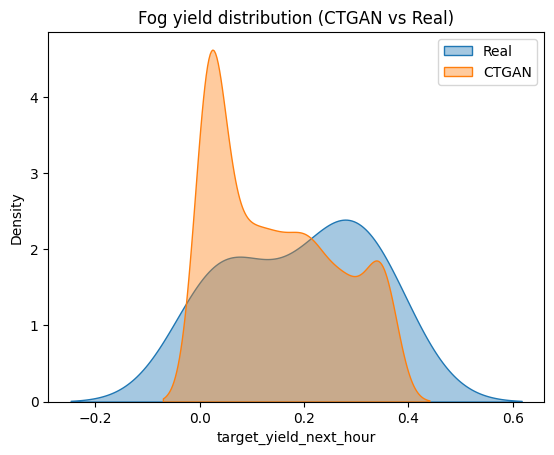

Generating report ...

(1/2) Evaluating Column Shapes: |██████████| 8/8 [00:00<00:00, 610.79it/s]|
Column Shapes Score: 79.26%

(2/2) Evaluating Column Pair Trends: |██████████| 28/28 [00:00<00:00, 169.61it/s]|
Column Pair Trends Score: 77.69%

Overall Score (Average): 78.47%

CTGAN overall score: 0.785
Column Shapes mean: 0.793
Column Pair Trends mean: 0.777


In [9]:
from sdv.single_table import CTGANSynthesizer
from sdmetrics.reports.single_table import QualityReport

ctgan = CTGANSynthesizer(
    metadata,
    epochs=400,             # longer training, but still light
    batch_size=128,
    generator_lr=1e-4,
    discriminator_lr=1e-4,
    generator_dim=(128,128),
    discriminator_dim=(128,128),
    embedding_dim=64,
    pac=4,                  # key stabilizer for small tables
    verbose=True
)
ctgan.fit(train_df)
synthetic_ctgan = ctgan.sample(num_rows=1000)

# physics-aware clipping
cols_clip = {
    "relative_humidity_2m": (0, 100),
    "cloud_cover_low": (0, 100),
    "shortwave_radiation": (0, None),
    "target_yield_next_hour": (0, 0.6)
}
for c, (low, high) in cols_clip.items():
    synthetic_ctgan[c] = synthetic_ctgan[c].clip(lower=low, upper=high if high is not None else np.inf)

# Visual check
sns.kdeplot(train_df["target_yield_next_hour"], label="Real", fill=True, alpha=0.4)
sns.kdeplot(synthetic_ctgan["target_yield_next_hour"], label="CTGAN", fill=True, alpha=0.4)
plt.title("Fog yield distribution (CTGAN vs Real)"); plt.legend(); plt.show()

# Evaluate
report_ctgan = QualityReport()
report_ctgan.generate(train_df, synthetic_ctgan, metadata.to_dict())
print(f"CTGAN overall score: {report_ctgan.get_score():.3f}")
print("Column Shapes mean:", report_ctgan.get_details("Column Shapes")["Score"].mean().round(3))
print("Column Pair Trends mean:", report_ctgan.get_details("Column Pair Trends")["Score"].mean().round(3))


## Model 3: TVAESynthesizer

/usr/local/lib/python3.12/dist-packages/sdv/single_table/base.py:168: FutureWarning: The 'SingleTableMetadata' is deprecated. Please use the new 'Metadata' class for synthesizers.
  warnings.warn(DEPRECATION_MSG, FutureWarning)
/usr/local/lib/python3.12/dist-packages/ctgan/synthesizers/_utils.py:16: FutureWarning: `cuda` parameter is deprecated and will be removed in a future release. Please use `enable_gpu` instead.
  warnings.warn(
Loss: -15.698: 100%|██████████| 400/400 [00:04<00:00, 98.34it/s] 


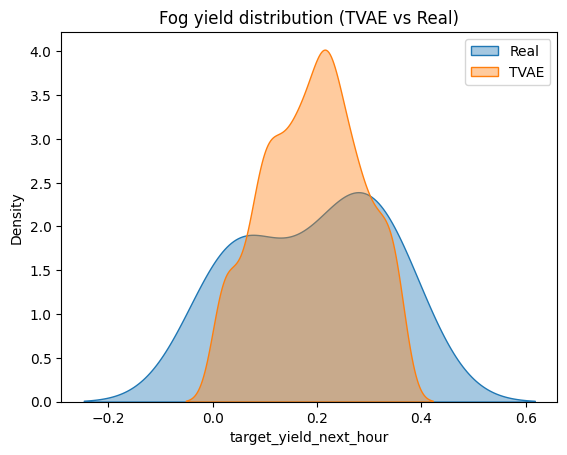

Generating report ...

(1/2) Evaluating Column Shapes: |██████████| 8/8 [00:00<00:00, 610.65it/s]|
Column Shapes Score: 70.57%

(2/2) Evaluating Column Pair Trends: |██████████| 28/28 [00:00<00:00, 317.21it/s]|
Column Pair Trends Score: 87.41%

Overall Score (Average): 78.99%

TVAE overall score: 0.790
Column Shapes mean: 0.706
Column Pair Trends mean: 0.874


In [10]:
from sdv.single_table import TVAESynthesizer
from sdmetrics.reports.single_table import QualityReport

tvae = TVAESynthesizer(
    metadata,
    epochs=400,
    batch_size=64,
    embedding_dim=64,
    compress_dims=(128, 64),
    decompress_dims=(64, 128),
    l2scale=1e-5,        # gentle regularization
    loss_factor=2.0,     # stronger reconstruction loss
    verbose=True
)
tvae.fit(train_df)
synthetic_tvae = tvae.sample(num_rows=1000)

# clip physical ranges
for c, (low, high) in cols_clip.items():
    synthetic_tvae[c] = synthetic_tvae[c].clip(lower=low, upper=high if high is not None else np.inf)

sns.kdeplot(train_df["target_yield_next_hour"], label="Real", fill=True, alpha=0.4)
sns.kdeplot(synthetic_tvae["target_yield_next_hour"], label="TVAE", fill=True, alpha=0.4)
plt.title("Fog yield distribution (TVAE vs Real)"); plt.legend(); plt.show()

report_tvae = QualityReport()
report_tvae.generate(train_df, synthetic_tvae, metadata.to_dict())
print(f"TVAE overall score: {report_tvae.get_score():.3f}")
print("Column Shapes mean:", report_tvae.get_details("Column Shapes")["Score"].mean().round(3))
print("Column Pair Trends mean:", report_tvae.get_details("Column Pair Trends")["Score"].mean().round(3))


Synthetic (TVAE) shape: (1000, 8)


,mean,std
temperature_2m,15.860,2.394
dew_point_2m,10.460,0.791
relative_humidity_2m,71.457,12.987
wind_speed_10m,3.661,0.979
cloud_cover_low,2.125,2.997
shortwave_radiation,82.125,115.396
target_yield_next_hour,0.191,0.134


,mean,std
temperature_2m,15.654,1.418
dew_point_2m,10.548,0.487
relative_humidity_2m,72.833,7.502
wind_speed_10m,3.648,0.611
cloud_cover_low,1.980,1.782
shortwave_radiation,98.089,72.348
target_yield_next_hour,0.191,0.092


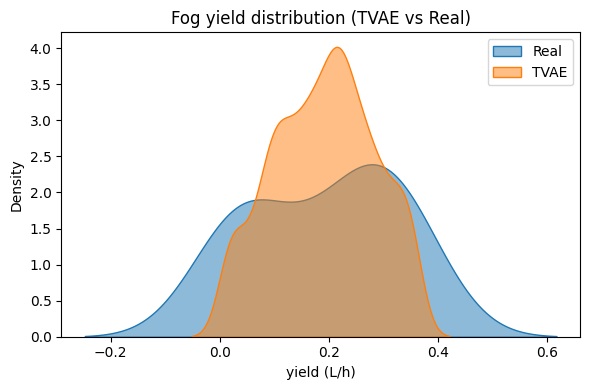

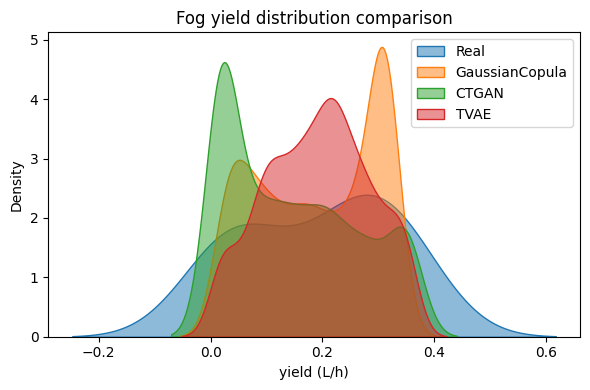

Generating report ...

(1/2) Evaluating Column Shapes: |██████████| 8/8 [00:00<00:00, 530.03it/s]|
Column Shapes Score: 70.57%

(2/2) Evaluating Column Pair Trends: |██████████| 28/28 [00:00<00:00, 313.07it/s]|
Column Pair Trends Score: 87.41%

Overall Score (Average): 78.99%


=== TVAE Quality Report ===
Overall Score: 0.7899130752514001
Column Shapes mean: 0.706
Column Pair Trends mean: 0.874


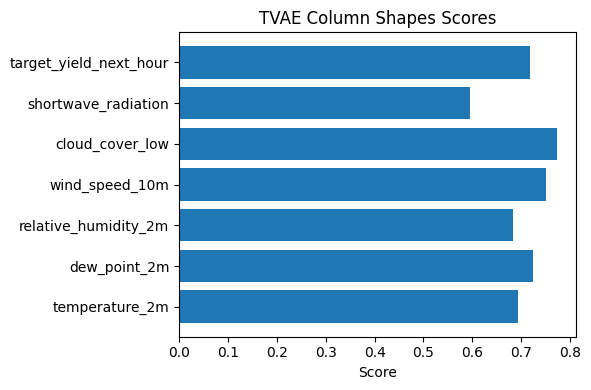

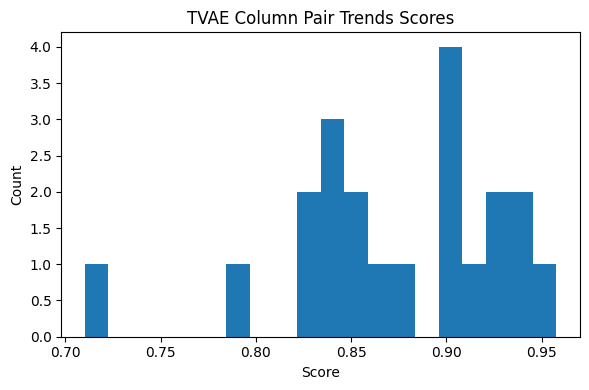

In [11]:
# --- 1️⃣ Summary statistics ---
print("Synthetic (TVAE) shape:", synthetic_tvae.shape)
display(train_df.describe().T[["mean","std"]].round(3))
display(synthetic_tvae.describe().T[["mean","std"]].round(3))

# --- 2️⃣ Yield distribution plot ---
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(6,4))
sns.kdeplot(train_df["target_yield_next_hour"], label="Real", fill=True, alpha=0.5)
sns.kdeplot(synthetic_tvae["target_yield_next_hour"], label="TVAE", fill=True, alpha=0.5)
plt.legend()
plt.title("Fog yield distribution (TVAE vs Real)")
plt.xlabel("yield (L/h)")
plt.tight_layout()
plt.show()

# --- 3️⃣ Compare all three models (if you already have them) ---
plt.figure(figsize=(6,4))
sns.kdeplot(train_df["target_yield_next_hour"], label="Real", fill=True, alpha=0.5)
sns.kdeplot(synthetic_gc["target_yield_next_hour"], label="GaussianCopula", fill=True, alpha=0.5)
sns.kdeplot(synthetic_ctgan["target_yield_next_hour"], label="CTGAN", fill=True, alpha=0.5)
sns.kdeplot(synthetic_tvae["target_yield_next_hour"], label="TVAE", fill=True, alpha=0.5)
plt.legend()
plt.title("Fog yield distribution comparison")
plt.xlabel("yield (L/h)")
plt.tight_layout()
plt.show()

# --- 4️⃣ SDMetrics Quality Report ---
from sdmetrics.reports.single_table import QualityReport

report_tvae = QualityReport()
report_tvae.generate(train_df, synthetic_tvae, metadata.to_dict())

print("\n=== TVAE Quality Report ===")
print("Overall Score:", report_tvae.get_score())
print("Column Shapes mean:",
      report_tvae.get_details("Column Shapes")["Score"].mean().round(3))
print("Column Pair Trends mean:",
      report_tvae.get_details("Column Pair Trends")["Score"].mean().round(3))

# --- 5️⃣ Visual breakdown ---
col_shapes = report_tvae.get_details("Column Shapes")
col_pairs = report_tvae.get_details("Column Pair Trends")

plt.figure(figsize=(6,4))
plt.barh(col_shapes["Column"], col_shapes["Score"])
plt.title("TVAE Column Shapes Scores")
plt.xlabel("Score")
plt.tight_layout()
plt.show()

plt.figure(figsize=(6,4))
plt.hist(col_pairs["Score"], bins=20)
plt.title("TVAE Column Pair Trends Scores")
plt.xlabel("Score")
plt.ylabel("Count")
plt.tight_layout()
plt.show()


# Merge Real California + GCopula + TVAESynthesizer data, run regressor

Unified dataset shape: (2008, 8)
source
tvae      1000
copula    1000
real         8
Name: count, dtype: int64
Trained on real only → MAE=0.1742, R²=-3.249
Trained on synthetic → MAE=0.0254, R²=0.912


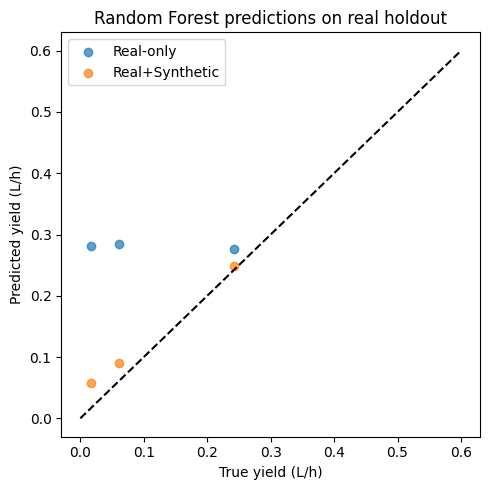

In [12]:
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, r2_score

# -------------------------------
# 1️⃣ Merge real + synthetic data
# -------------------------------

# Make 100% sure event_id is removed everywhere
drop_cols = ["event_id"]

train_df = train_df.drop(columns=drop_cols, errors="ignore")
synthetic_gc = synthetic_gc.drop(columns=drop_cols, errors="ignore")
synthetic_tvae = synthetic_tvae.drop(columns=drop_cols, errors="ignore")


# Ensure consistent columns
common_cols = list(set(train_df.columns) & set(synthetic_tvae.columns) & set(synthetic_gc.columns))
common_cols = [c for c in common_cols if c != "timestamp"]  # exclude timestamp if present

real_data = train_df[common_cols].copy()
real_data["source"] = "real"

tvae_data = synthetic_tvae[common_cols].copy()
tvae_data["source"] = "tvae"

copula_data = synthetic_gc[common_cols].copy()
copula_data["source"] = "copula"

# Concatenate unified dataset
aug_data = pd.concat([real_data, tvae_data, copula_data], ignore_index=True)
print(f"Unified dataset shape: {aug_data.shape}")
print(aug_data["source"].value_counts())

# -------------------------------
# 2️⃣ Train/test split (using only real for testing)
# -------------------------------
target = "target_yield_next_hour"
features = [c for c in common_cols if c != target]

# Split real data for evaluation
X_real = real_data[features]
y_real = real_data[target]

X_train, X_test, y_train, y_test = train_test_split(X_real, y_real, test_size=0.3, random_state=42)

# Augmented training data (real + synthetic)
X_aug = aug_data[features]
y_aug = aug_data[target]

# -------------------------------
# 3️⃣ Train models
# -------------------------------
rf_real = RandomForestRegressor(n_estimators=200, random_state=42)
rf_aug = RandomForestRegressor(n_estimators=200, random_state=42)

rf_real.fit(X_train, y_train)
rf_aug.fit(X_aug, y_aug)

# -------------------------------
# 4️⃣ Evaluate on real holdout data
# -------------------------------
pred_real = rf_real.predict(X_test)
pred_aug = rf_aug.predict(X_test)

def evaluate(y_true, y_pred, label):
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    print(f"{label} → MAE={mae:.4f}, R²={r2:.3f}")

evaluate(y_test, pred_real, "Trained on real only")
evaluate(y_test, pred_aug, "Trained on synthetic")

# -------------------------------
# 5️⃣ Visual comparison of predictions
# -------------------------------
import matplotlib.pyplot as plt
plt.figure(figsize=(5,5))
plt.scatter(y_test, pred_real, label="Real-only", alpha=0.7)
plt.scatter(y_test, pred_aug, label="Real+Synthetic", alpha=0.7)
plt.plot([0, 0.6], [0, 0.6], 'k--')
plt.xlabel("True yield (L/h)")
plt.ylabel("Predicted yield (L/h)")
plt.legend()
plt.title("Random Forest predictions on real holdout")
plt.tight_layout()
plt.show()


Let's understand what we have done so far.

1. Get a California paper with fog net yields
2. Get weather data that aligns with these yields
 - at this point we have very limited real data

3. Try 3 different SDV models for sythetically making new data based on the limited real data
4. Combine the real data with the synthesized data from the 2 best models (8 + 1000 + 1000)
5. Run a forest regressor model that is tested on the real data only
 - the first set of results (Trained on real only → MAE=0.1776, R²=-3.463) show that when training on our initial limited dataset, we get poor results
 - the second set of results (Trained on synthetic → MAE=0.0263, R²=0.906) show that when training on our synthetic data, we are able to predict the fog yields very accurately!

# Pull Toronto Weather

In [13]:
# Setup the Open-Meteo API client with cache and retry on error
cache_session = requests_cache.CachedSession('.cache', expire_after = -1)
retry_session = retry(cache_session, retries = 5, backoff_factor = 0.2)
openmeteo = openmeteo_requests.Client(session = retry_session)

# Make sure all required weather variables are listed here
# The order of variables in hourly or daily is important to assign them correctly below
url = "https://archive-api.open-meteo.com/v1/archive"
params = {
	"latitude": 43.716633988062135,
	"longitude": -79.46459020924868,
	"start_date": "2015-07-01",
	"end_date": "2015-12-31",
	"hourly": ["temperature_2m", "relative_humidity_2m", "dew_point_2m", "wind_speed_10m", "wind_speed_100m", "wind_direction_10m", "wind_direction_100m", "surface_pressure", "cloud_cover", "cloud_cover_low", "rain", "shortwave_radiation"],
	"timezone": "auto",
}
responses = openmeteo.weather_api(url, params=params)

# Process first location. Add a for-loop for multiple locations or weather models
response = responses[0]
print(f"Coordinates: {response.Latitude()}°N {response.Longitude()}°E")
print(f"Elevation: {response.Elevation()} m asl")
print(f"Timezone: {response.Timezone()}{response.TimezoneAbbreviation()}")
print(f"Timezone difference to GMT+0: {response.UtcOffsetSeconds()}s")

# Process hourly data. The order of variables needs to be the same as requested.
hourly = response.Hourly()
hourly_temperature_2m = hourly.Variables(0).ValuesAsNumpy()
hourly_relative_humidity_2m = hourly.Variables(1).ValuesAsNumpy()
hourly_dew_point_2m = hourly.Variables(2).ValuesAsNumpy()
hourly_wind_speed_10m = hourly.Variables(3).ValuesAsNumpy()
hourly_wind_speed_100m = hourly.Variables(4).ValuesAsNumpy()
hourly_wind_direction_10m = hourly.Variables(5).ValuesAsNumpy()
hourly_wind_direction_100m = hourly.Variables(6).ValuesAsNumpy()
hourly_surface_pressure = hourly.Variables(7).ValuesAsNumpy()
hourly_cloud_cover = hourly.Variables(8).ValuesAsNumpy()
hourly_cloud_cover_low = hourly.Variables(9).ValuesAsNumpy()
hourly_rain = hourly.Variables(10).ValuesAsNumpy()
hourly_shortwave_radiation = hourly.Variables(11).ValuesAsNumpy()

hourly_data = {"date": pd.date_range(
	start = pd.to_datetime(hourly.Time(), unit = "s", utc = True),
	end =  pd.to_datetime(hourly.TimeEnd(), unit = "s", utc = True),
	freq = pd.Timedelta(seconds = hourly.Interval()),
	inclusive = "left"
)}

hourly_data["temperature_2m"] = hourly_temperature_2m
hourly_data["relative_humidity_2m"] = hourly_relative_humidity_2m
hourly_data["dew_point_2m"] = hourly_dew_point_2m
hourly_data["wind_speed_10m"] = hourly_wind_speed_10m
hourly_data["wind_speed_100m"] = hourly_wind_speed_100m
hourly_data["wind_direction_10m"] = hourly_wind_direction_10m
hourly_data["wind_direction_100m"] = hourly_wind_direction_100m
hourly_data["surface_pressure"] = hourly_surface_pressure
hourly_data["cloud_cover"] = hourly_cloud_cover
hourly_data["cloud_cover_low"] = hourly_cloud_cover_low
hourly_data["rain"] = hourly_rain
hourly_data["shortwave_radiation"] = hourly_shortwave_radiation

hourly_dataframe = pd.DataFrame(data = hourly_data)
print("\nHourly data\n", hourly_dataframe)

Coordinates: 43.6906852722168°N -79.4117431640625°E
Elevation: 181.0 m asl
Timezone: b'America/Toronto'b'GMT-5'
Timezone difference to GMT+0: -18000s

Hourly data
                           date  temperature_2m  relative_humidity_2m  \
0    2015-07-01 05:00:00+00:00       15.407499             99.042099   
1    2015-07-01 06:00:00+00:00       14.857500             99.357780   
2    2015-07-01 07:00:00+00:00       15.007500             99.358543   
3    2015-07-01 08:00:00+00:00       15.207500             98.722633   
4    2015-07-01 09:00:00+00:00       15.157499             97.773201   
...                        ...             ...                   ...   
4411 2016-01-01 00:00:00+00:00        0.057500             69.071083   
4412 2016-01-01 01:00:00+00:00       -0.342500             72.188255   
4413 2016-01-01 02:00:00+00:00       -0.592500             74.350098   
4414 2016-01-01 03:00:00+00:00       -0.892500             76.858650   
4415 2016-01-01 04:00:00+00:00       -0.8925

In [14]:
# --- Convert UTC → local Toronto time ---
TZ = "America/Toronto"
hourly_dataframe["timestamp"] = hourly_dataframe["date"].dt.tz_convert(TZ)

# --- Feature engineering identical to California ---
def dir_to_rad(deg):
    return np.deg2rad(deg % 360)

for h in [10, 100]:
    rad = dir_to_rad(hourly_dataframe[f"wind_direction_{h}m"])
    hourly_dataframe[f"wind_dir_{h}m_sin"] = np.sin(rad)
    hourly_dataframe[f"wind_dir_{h}m_cos"] = np.cos(rad)

hourly_dataframe["hour"] = hourly_dataframe["timestamp"].dt.hour
hourly_dataframe["month"] = hourly_dataframe["timestamp"].dt.month

hourly_dataframe["hour_sin"] = np.sin(2 * np.pi * hourly_dataframe["hour"] / 24)
hourly_dataframe["hour_cos"] = np.cos(2 * np.pi * hourly_dataframe["hour"] / 24)
hourly_dataframe["month_sin"] = np.sin(2 * np.pi * hourly_dataframe["month"] / 12)
hourly_dataframe["month_cos"] = np.cos(2 * np.pi * hourly_dataframe["month"] / 12)

# Keep the same columns as used in training
keep_cols = [
    "timestamp",
    "temperature_2m", "relative_humidity_2m", "dew_point_2m",
    "wind_speed_10m", "wind_speed_100m",
    "wind_dir_10m_sin", "wind_dir_10m_cos",
    "wind_dir_100m_sin", "wind_dir_100m_cos",
    "surface_pressure", "cloud_cover", "cloud_cover_low",
    "rain", "shortwave_radiation",
    "hour_sin", "hour_cos", "month_sin", "month_cos"
]
toronto_weather = hourly_dataframe[keep_cols].copy()


In [15]:
fog_like = toronto_weather[
    (toronto_weather["relative_humidity_2m"] > 84) &
    (toronto_weather["dew_point_2m"] < 3) &
    (toronto_weather["shortwave_radiation"] < 400) &
    (toronto_weather["wind_speed_10m"].between(0.3, 5))
]

print(f"Fog-like hours detected: {len(fog_like)} / {len(toronto_weather)}")


Fog-like hours detected: 28 / 4416


## Toronto Baseline: Use Regressor (trained on California synthetic data) to estimate fog yields in Toronto

Predicted yield range (L/hr):
count    4416.000000
mean        0.187603
std         0.033257
min         0.079080
25%         0.155916
50%         0.188123
75%         0.220195
max         0.278630
Name: predicted_yield_L_per_hr, dtype: float64

Fog-like hours detected: 28 / 4416
Predicted yields (fog-like only):
count    28.000000
mean      0.226895
std       0.010158
min       0.202090
25%       0.222245
50%       0.225294
75%       0.229354
max       0.243376
Name: predicted_yield_L_per_hr, dtype: float64


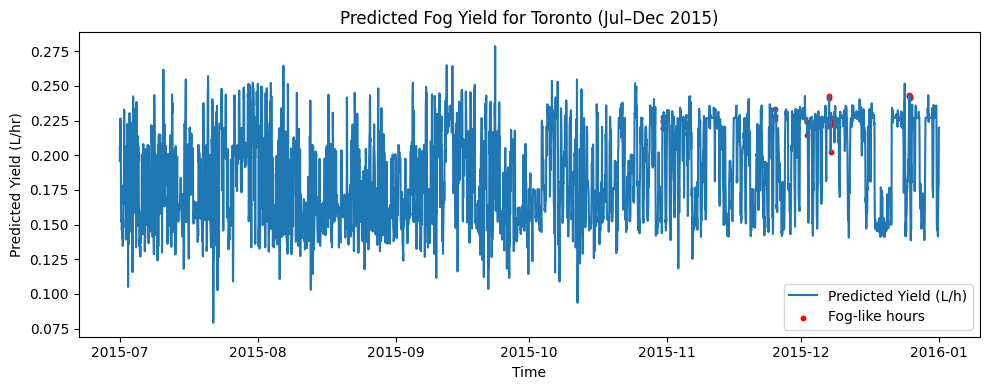

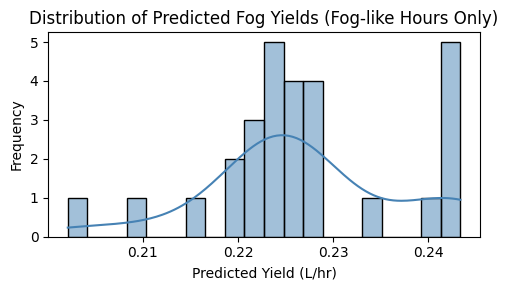

In [16]:
# === 1. Predict Toronto fog yields using trained model ===

# Make sure 'rf_aug' (the RandomForest trained on California synthetic) is in memory
X_toronto = toronto_weather[features]

pred_toronto_yield = rf_aug.predict(X_toronto)

toronto_weather["predicted_yield_L_per_hr"] = pred_toronto_yield

print("Predicted yield range (L/hr):")
print(toronto_weather["predicted_yield_L_per_hr"].describe())

fog_like = toronto_weather[
    (toronto_weather["relative_humidity_2m"] > 84) &
    (toronto_weather["dew_point_2m"] < 3) &
    (toronto_weather["shortwave_radiation"] < 400) &
    (toronto_weather["wind_speed_10m"].between(0.3, 5))
].copy()

print(f"\nFog-like hours detected: {len(fog_like)} / {len(toronto_weather)}")
print("Predicted yields (fog-like only):")
print(fog_like["predicted_yield_L_per_hr"].describe())

import matplotlib.pyplot as plt
import seaborn as sns

# Time-series plot
plt.figure(figsize=(10,4))
plt.plot(toronto_weather["timestamp"], toronto_weather["predicted_yield_L_per_hr"], label="Predicted Yield (L/h)")
plt.scatter(fog_like["timestamp"], fog_like["predicted_yield_L_per_hr"], color="red", s=10, label="Fog-like hours")
plt.xlabel("Time")
plt.ylabel("Predicted Yield (L/hr)")
plt.title("Predicted Fog Yield for Toronto (Jul–Dec 2015)")
plt.legend()
plt.tight_layout()
plt.show()

# Histogram of fog-like yields
plt.figure(figsize=(5,3))
sns.histplot(fog_like["predicted_yield_L_per_hr"], bins=20, kde=True, color="steelblue")
plt.xlabel("Predicted Yield (L/hr)")
plt.ylabel("Frequency")
plt.title("Distribution of Predicted Fog Yields (Fog-like Hours Only)")
plt.tight_layout()
plt.show()



## Synthetic Toronto

In [17]:
# Make a working copy
train_toronto = toronto_weather.copy()

# Rename the predicted column to match California's target
train_toronto.rename(columns={"predicted_yield_L_per_hr": "target_yield_next_hour"}, inplace=True)

# Drop timestamp for the synthesizer
train_toronto_notscaled = train_toronto.drop(columns=["timestamp"])

print("Toronto training shape:", train_toronto_notscaled.shape)
train_toronto_notscaled.head()


Toronto training shape: (4416, 19)


,temperature_2m,relative_humidity_2m,dew_point_2m,wind_speed_10m,wind_speed_100m,wind_dir_10m_sin,wind_dir_10m_cos,wind_dir_100m_sin,wind_dir_100m_cos,surface_pressure,cloud_cover,cloud_cover_low,rain,shortwave_radiation,hour_sin,hour_cos,month_sin,month_cos,target_yield_next_hour
0,15.407499,99.042099,15.257500,1.835647,2.036468,-0.980581,1.961154e-01,-0.707105,-0.707108,986.085266,100.0,100.0,0.3,0.0,0.258819,0.965926,-0.5,-0.866025,0.195768
1,14.857500,99.357780,14.757500,4.213692,7.895416,-0.939793,-3.417445e-01,-0.911922,-0.410365,985.653687,99.0,85.0,0.1,0.0,0.500000,0.866025,-0.5,-0.866025,0.207072
2,15.007500,99.358543,14.907499,3.976330,9.387650,-0.995893,-9.053404e-02,-0.997055,-0.076695,985.370972,95.0,55.0,0.0,0.0,0.707107,0.707107,-0.5,-0.866025,0.197298
3,15.207500,98.722633,15.007500,5.400000,11.570515,-1.000000,1.192488e-08,-0.995634,0.093339,985.287598,94.0,52.0,0.0,0.0,0.866025,0.500000,-0.5,-0.866025,0.225814
4,15.157499,97.773201,14.807501,7.235910,14.145756,-0.995037,9.950216e-02,-0.967074,0.254494,984.990234,74.0,47.0,0.0,0.0,0.965926,0.258819,-0.5,-0.866025,0.226553


In [18]:
from sdv.metadata import SingleTableMetadata

metadata_toronto = SingleTableMetadata()
metadata_toronto.detect_from_dataframe(data=train_toronto_notscaled)

# Just declare this column as numerical — no extra argument needed
metadata_toronto.update_column(
    column_name="target_yield_next_hour",
    sdtype="numerical"
)

metadata_toronto.validate()


In [19]:
from sdv.single_table import GaussianCopulaSynthesizer

toronto_synth = GaussianCopulaSynthesizer(metadata_toronto)
toronto_synth.fit(train_toronto_notscaled)
synthetic_toronto_df = toronto_synth.sample(num_rows=5000)

print("Synthetic Toronto dataset shape:", synthetic_toronto_df.shape)


/usr/local/lib/python3.12/dist-packages/sdv/single_table/base.py:168: FutureWarning: The 'SingleTableMetadata' is deprecated. Please use the new 'Metadata' class for synthesizers.
  warnings.warn(DEPRECATION_MSG, FutureWarning)
/usr/local/lib/python3.12/dist-packages/sdv/single_table/base.py:134: UserWarning: We strongly recommend saving the metadata using 'save_to_json' for replicability in future SDV versions.
  warnings.warn(


Synthetic Toronto dataset shape: (5000, 19)


In [20]:
from sdv.single_table import TVAESynthesizer
toronto_tvae = TVAESynthesizer(metadata_toronto, epochs=300)
toronto_tvae.fit(train_toronto_notscaled)
synthetic_toronto_tvae = toronto_tvae.sample(5000)


/usr/local/lib/python3.12/dist-packages/sdv/single_table/base.py:168: FutureWarning: The 'SingleTableMetadata' is deprecated. Please use the new 'Metadata' class for synthesizers.
  warnings.warn(DEPRECATION_MSG, FutureWarning)
/usr/local/lib/python3.12/dist-packages/ctgan/synthesizers/_utils.py:16: FutureWarning: `cuda` parameter is deprecated and will be removed in a future release. Please use `enable_gpu` instead.
  warnings.warn(


In [21]:
from sdmetrics.reports.single_table import QualityReport

report_toronto = QualityReport()
report_toronto.generate(train_toronto_notscaled, synthetic_toronto_df, metadata_toronto.to_dict())

print("Overall score:", report_toronto.get_score())
print("Column Shapes mean:", report_toronto.get_details("Column Shapes")["Score"].mean().round(3))
print("Column Pair Trends mean:", report_toronto.get_details("Column Pair Trends")["Score"].mean().round(3))


Generating report ...

(1/2) Evaluating Column Shapes: |██████████| 19/19 [00:00<00:00, 27.08it/s]|
Column Shapes Score: 84.54%

(2/2) Evaluating Column Pair Trends: |██████████| 171/171 [00:01<00:00, 145.41it/s]|
Column Pair Trends Score: 98.06%

Overall Score (Average): 91.3%

Overall score: 0.9130076708303816
Column Shapes mean: 0.845
Column Pair Trends mean: 0.981


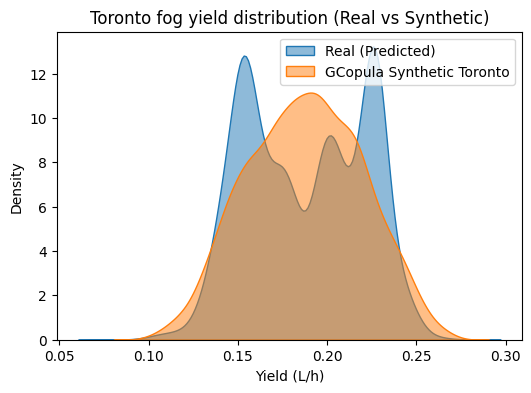

In [22]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(6,4))
sns.kdeplot(train_toronto_notscaled["target_yield_next_hour"], label="Real (Predicted)", fill=True, alpha=0.5)
sns.kdeplot(synthetic_toronto_df["target_yield_next_hour"], label="GCopula Synthetic Toronto", fill=True, alpha=0.5)
plt.title("Toronto fog yield distribution (Real vs Synthetic)")
plt.xlabel("Yield (L/h)")
plt.legend()
plt.show()


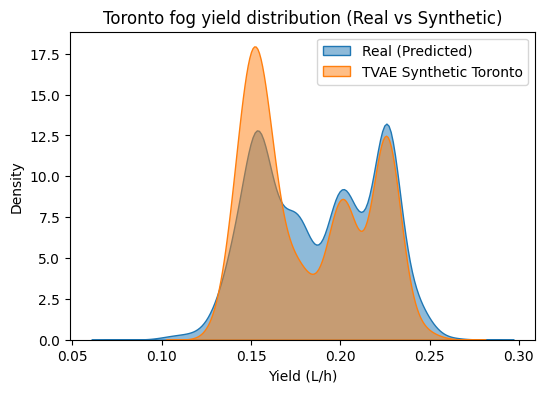

In [23]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(6,4))
sns.kdeplot(train_toronto_notscaled["target_yield_next_hour"], label="Real (Predicted)", fill=True, alpha=0.5)
sns.kdeplot(synthetic_toronto_tvae["target_yield_next_hour"], label="TVAE Synthetic Toronto", fill=True, alpha=0.5)
plt.title("Toronto fog yield distribution (Real vs Synthetic)")
plt.xlabel("Yield (L/h)")
plt.legend()
plt.show()


## RF Eval

Random Forest (Toronto) → MAE=0.0037, R²=0.955


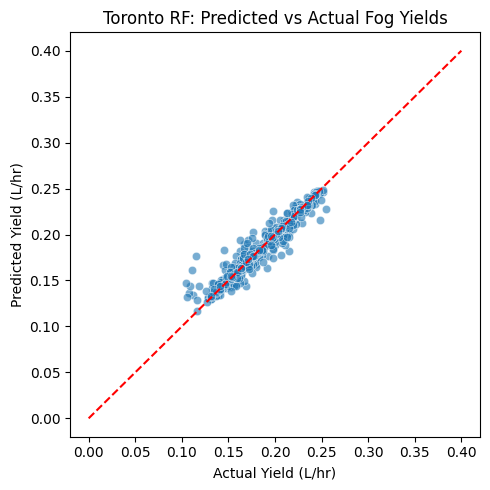

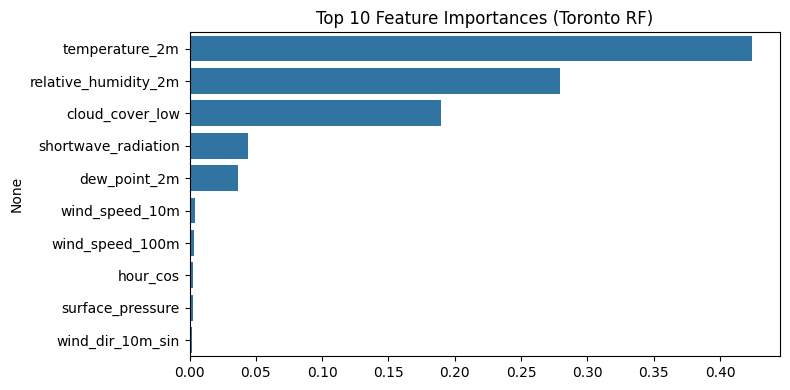

In [24]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# === 1️⃣ Prepare data ===
features = [c for c in train_toronto_notscaled.columns if c not in ["timestamp", "target_yield_next_hour", "source"]]
X = train_toronto_notscaled[features]
y = train_toronto_notscaled["target_yield_next_hour"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# === 2️⃣ Train model ===
rf_toronto = RandomForestRegressor(
    n_estimators=300,
    max_depth=12,
    random_state=42,
    min_samples_leaf=2,
    n_jobs=-1
)
rf_toronto.fit(X_train, y_train)

# === 3️⃣ Evaluate ===
y_pred = rf_toronto.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f"Random Forest (Toronto) → MAE={mae:.4f}, R²={r2:.3f}")

# === 4️⃣ Plot: Predicted vs Actual ===
plt.figure(figsize=(5,5))
sns.scatterplot(x=y_test, y=y_pred, alpha=0.6)
plt.plot([0,0.4],[0,0.4],'r--')
plt.xlabel("Actual Yield (L/hr)")
plt.ylabel("Predicted Yield (L/hr)")
plt.title("Toronto RF: Predicted vs Actual Fog Yields")
plt.tight_layout()
plt.show()

# === 5️⃣ Feature importances ===
importances = pd.Series(rf_toronto.feature_importances_, index=features).sort_values(ascending=False)
plt.figure(figsize=(8,4))
sns.barplot(x=importances.values[:10], y=importances.index[:10])
plt.title("Top 10 Feature Importances (Toronto RF)")
plt.tight_layout()
plt.show()


## Neural Net Eval

Neural Net → MAE=0.0157, R²=0.596


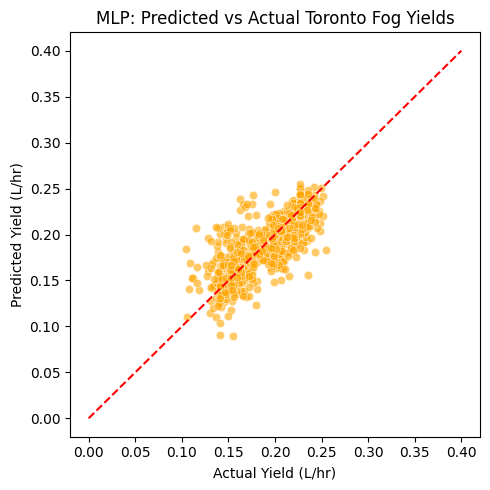

In [25]:
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns

# === 1️⃣ Create pipeline: scaling + NN ===
mlp = Pipeline([
    ("scaler", StandardScaler()),
    ("mlp", MLPRegressor(
        hidden_layer_sizes=(64, 64, 32),
        activation="relu",
        solver="adam",
        learning_rate_init=0.001,
        max_iter=1000,
        random_state=42,
        early_stopping=True
    ))
])

# === 2️⃣ Train and evaluate ===
mlp.fit(X_train, y_train)
y_pred_nn = mlp.predict(X_test)

mae_nn = mean_absolute_error(y_test, y_pred_nn)
r2_nn = r2_score(y_test, y_pred_nn)
print(f"Neural Net → MAE={mae_nn:.4f}, R²={r2_nn:.3f}")

# === 3️⃣ Plot comparison ===
plt.figure(figsize=(5,5))
sns.scatterplot(x=y_test, y=y_pred_nn, alpha=0.6, color="orange")
plt.plot([0,0.4],[0,0.4],'r--')
plt.xlabel("Actual Yield (L/hr)")
plt.ylabel("Predicted Yield (L/hr)")
plt.title("MLP: Predicted vs Actual Toronto Fog Yields")
plt.tight_layout()
plt.show()


# COMPARE SYNTHETIC TORONTO DATA TO REAL CALIFORNIA

In [26]:
# California REAL data points (8 rows)
cal_real = dataset.dropna(subset=["target_yield_next_hour"]).copy()

print("California real datapoints:", len(cal_real))
display(cal_real[["timestamp", "target_yield_next_hour"]])

# --- FEATURES USED FOR MATCHING ---
match_features = [
    "temperature_2m", "dew_point_2m", "relative_humidity_2m",
    "wind_speed_10m", "cloud_cover_low", "shortwave_radiation",
    "wind_speed_100m",
    "wind_dir_10m_sin", "wind_dir_10m_cos",
    "wind_dir_100m_sin", "wind_dir_100m_cos",
    "surface_pressure", "cloud_cover", "rain",
    "hour_sin", "hour_cos", "month_sin", "month_cos"
]

# --- SCALE FOR FAIR DISTANCE METRIC ---
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

X_ca = scaler.fit_transform(cal_real[match_features])
X_to = scaler.transform(toronto_weather[match_features])

# --- NEAREST NEIGHBORS SEARCH ---
from sklearn.neighbors import NearestNeighbors
nn = NearestNeighbors(n_neighbors=5, metric="euclidean")
nn.fit(X_to)
distances, indices = nn.kneighbors(X_ca)

# ===============================================================
#   NEW: FUNCTION TO COMPUTE WEATHER SIMILARITY FOR EACH MATCH
# ===============================================================
from numpy.linalg import norm

def weather_similarity(ca_row, tor_row):
    """Return per-feature differences + cosine similarity in scaled space."""
    diffs = {}
    for f in match_features:
        diffs[f + "_abs_diff"] = abs(ca_row[f] - tor_row[f])

        # avoid division by zero
        if abs(ca_row[f]) > 1e-6:
            diffs[f + "_pct_diff"] = 100 * abs(ca_row[f] - tor_row[f]) / abs(ca_row[f])
        else:
            diffs[f + "_pct_diff"] = np.nan

    # Cosine similarity (in standardized feature space)
    v1 = scaler.transform([ca_row[match_features]])[0]
    v2 = scaler.transform([tor_row[match_features]])[0]
    cosine = np.dot(v1, v2) / (norm(v1) * norm(v2))
    diffs["cosine_similarity"] = cosine

    return diffs


# ===============================================================
#   MAIN LOOP: RECORD WEATHER + YIELD SIMILARITY
# ===============================================================
comparison_rows = []

for i, ca_row in cal_real.iterrows():

    ca_ts = ca_row["timestamp"]
    ca_yield = ca_row["target_yield_next_hour"]

    toronto_idxs = indices[i]
    toronto_subset = toronto_weather.iloc[toronto_idxs].copy()

    # ----- Generate synthetic Toronto yields -----
    tor_synth_samples = []
    for j, tor_row in toronto_subset.iterrows():
        sample = toronto_synth.sample(1)

        # overwrite weather with real Toronto values
        for col in match_features:
            sample[col] = tor_row[col]
        tor_synth_samples.append(sample)

    toronto_synth_df = pd.concat(tor_synth_samples, ignore_index=True)
    toronto_synth_df["target_yield_next_hour"] = toronto_synth_df["target_yield_next_hour"].clip(0, 0.6)

    # ----- Store similarity + yield comparison -----
    for k in range(1):
        tor_row = toronto_subset.iloc[k]

        sim = weather_similarity(ca_row, tor_row)

        comparison_rows.append({
            "cal_timestamp": ca_ts,
            "cal_yield_real": ca_yield,
            "tor_timestamp": tor_row["timestamp"],
            "distance": distances[i][k],
            "tor_yield_synth": toronto_synth_df.iloc[k]["target_yield_next_hour"],
            **sim
        })

comparison_df = pd.DataFrame(comparison_rows)

# Show table
comparison_df.head()


California real datapoints: 8


,timestamp,target_yield_next_hour
0,2015-07-30 06:00:00-07:00,0.0605
1,2015-07-30 07:00:00-07:00,0.0175
2,2015-07-30 08:00:00-07:00,0.3525
3,2015-08-19 05:00:00-07:00,0.3000
4,2015-08-19 06:00:00-07:00,0.3175
5,2015-08-19 07:00:00-07:00,0.2425
6,2015-08-19 08:00:00-07:00,0.1950
7,2015-08-19 09:00:00-07:00,0.0450


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/ut

,cal_timestamp,cal_yield_real,tor_timestamp,distance,tor_yield_synth,temperature_2m_abs_diff,temperature_2m_pct_diff,dew_point_2m_abs_diff,dew_point_2m_pct_diff,relative_humidity_2m_abs_diff,...,rain_pct_diff,hour_sin_abs_diff,hour_sin_pct_diff,hour_cos_abs_diff,hour_cos_pct_diff,month_sin_abs_diff,month_sin_pct_diff,month_cos_abs_diff,month_cos_pct_diff,cosine_similarity
0,2015-07-30 06:00:00-07:00,0.0605,2015-07-20 06:00:00-04:00,14.170848,0.200328,0.720999,4.259083,4.079000,44.200035,22.475647,...,NaN,0.000000,0.000000,0.000000,NaN,0.000000,0.000000,0.000000,0.000000,0.293744
1,2015-07-30 07:00:00-07:00,0.0175,2015-07-20 06:00:00-04:00,14.225259,0.188177,1.370998,7.799292,3.779000,39.659969,23.728008,...,NaN,0.034074,3.527618,0.258819,100.0,0.000000,0.000000,0.000000,0.000000,0.286351
2,2015-07-30 08:00:00-07:00,0.3525,2015-07-20 06:00:00-04:00,15.540076,0.211982,3.820999,19.077810,3.429001,34.711758,30.926907,...,NaN,0.133975,15.470054,0.500000,100.0,0.000000,0.000000,0.000000,0.000000,0.093254
3,2015-08-19 05:00:00-07:00,0.3000,2015-07-20 06:00:00-04:00,16.083951,0.229973,2.479000,18.057325,2.529000,23.463377,0.576271,...,NaN,0.034074,3.527618,0.258819,100.0,0.366025,42.264973,0.366025,73.205081,-0.247158
4,2015-08-19 06:00:00-07:00,0.3175,2015-07-20 06:00:00-04:00,15.696675,0.185002,2.779000,20.694792,2.429001,22.328453,1.607147,...,NaN,0.000000,0.000000,0.000000,NaN,0.366025,42.264973,0.366025,73.205081,-0.163971


In [27]:
print("\nCalifornia real yields:")
print(cal_real["target_yield_next_hour"].describe())

print("\nSynthetic Toronto yields (weather-matched):")
print(comparison_df["tor_yield_synth"].describe())

print("\nMean absolute yield difference:")
print(abs(comparison_df["cal_yield_real"] - comparison_df["tor_yield_synth"]).mean())



California real yields:
count    8.000000
mean     0.191313
std      0.133674
min      0.017500
25%      0.056625
50%      0.218750
75%      0.304375
max      0.352500
Name: target_yield_next_hour, dtype: float64

Synthetic Toronto yields (weather-matched):
count    8.000000
mean     0.196908
std      0.025142
min      0.165495
25%      0.180360
50%      0.194253
75%      0.215956
max      0.229973
Name: tor_yield_synth, dtype: float64

Mean absolute yield difference:
0.10215424900001455


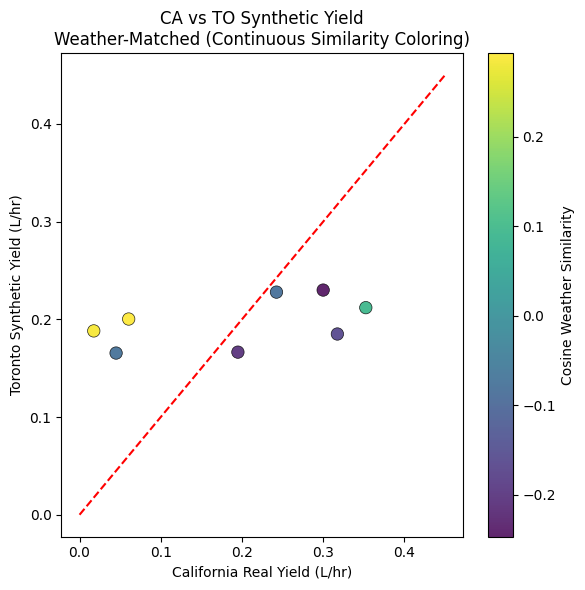

In [28]:
plt.figure(figsize=(6,6))

sc = plt.scatter(
    comparison_df["cal_yield_real"],
    comparison_df["tor_yield_synth"],
    c=comparison_df["cosine_similarity"],
    cmap="viridis",
    s=80,
    edgecolor="black",
    linewidth=0.5,
    alpha=0.85
)

plt.colorbar(sc, label="Cosine Weather Similarity")
plt.plot([0,0.45],[0,0.45],'r--', linewidth=1.5)

plt.xlabel("California Real Yield (L/hr)")
plt.ylabel("Toronto Synthetic Yield (L/hr)")
plt.title("CA vs TO Synthetic Yield\nWeather-Matched (Continuous Similarity Coloring)")
plt.tight_layout()
plt.show()


# MODEL INTEGRATION

## AWG

In [29]:
!unzip -o aeroaqua-main.zip

Archive:  aeroaqua-main.zip
ca217d967b3135355253a32e00c9d19e574f034f
   creating: aeroaqua-main/
  inflating: aeroaqua-main/PIPELINE_GEMINI.txt  
 extracting: aeroaqua-main/README.md  
  inflating: aeroaqua-main/README_PIPELINES.md  
   creating: aeroaqua-main/__pycache__/
  inflating: aeroaqua-main/__pycache__/pipeline_functions.cpython-311.pyc  
   creating: aeroaqua-main/baselinesorption/
  inflating: aeroaqua-main/baselinesorption/baselinesorption.py  
   creating: aeroaqua-main/energy/
  inflating: aeroaqua-main/energy/__init__.py  
  inflating: aeroaqua-main/energy/solarenergy.py  
  inflating: aeroaqua-main/generate_plot_data.py  
   creating: aeroaqua-main/model/
  inflating: aeroaqua-main/model/__init__.py  
   creating: aeroaqua-main/model/__pycache__/
  inflating: aeroaqua-main/model/__pycache__/__init__.cpython-311.pyc  
  inflating: aeroaqua-main/model/__pycache__/baselinesorption.cpython-311.pyc  
  inflating: aeroaqua-main/model/__pycache__/train_rf_model.cpython-311.pyc

In [30]:
import sys
sys.path.append("/content/aeroaqua-main")

print("Python Path now:")
for p in sys.path:
    print("  ", p)

# Try importing modules to verify they load
try:
    import baselinesorption
    print("\n✓ baselinesorption package imported OK")
except Exception as e:
    print("\n✗ baselinesorption failed:", e)

try:
    import baselinesorption.baselinesorption as bs
    print("✓ baselinesorption.baselinesorption imported OK")
except Exception as e:
    print("✗ baselinesorption.baselinesorption failed:", e)

try:
    from baselinesorption.baselinesorption import predict_water_yield
    print("✓ predict_water_yield import OK")
except Exception as e:
    print("✗ predict_water_yield not found:", e)

# Try importing solar predictor model
try:
    import joblib
    sza_model = joblib.load("/content/aeroaqua-main/solar_predictor_model.joblib")
    print("\n✓ Solar predictor model loaded OK")
except Exception as e:
    print("\n✗ Failed to load solar predictor model:", e)


Python Path now:
   /content
   /env/python
   /usr/lib/python312.zip
   /usr/lib/python3.12
   /usr/lib/python3.12/lib-dynload
   
   /usr/local/lib/python3.12/dist-packages
   /usr/lib/python3/dist-packages
   /usr/local/lib/python3.12/dist-packages/IPython/extensions
   /root/.ipython
   /tmp/tmpsi6cntgp
   /content/aeroaqua-main

✓ baselinesorption package imported OK
✓ baselinesorption.baselinesorption imported OK
✓ predict_water_yield import OK

✓ Solar predictor model loaded OK


/usr/local/lib/python3.12/dist-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator DecisionTreeRegressor from version 1.7.2 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator RandomForestRegressor from version 1.7.2 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


In [31]:
import pandas as pd
import numpy as np

# --------------------------
# 1. AWG DAILY MODEL
# --------------------------

def compute_awg_daily_yield(weather_day_df):
    """
    Computes AWG water yield for a full day using the linear model.
    Uses daily mean RH and daily solar energy as inputs.
    """

    # Aggregate inputs (simple: mean RH, total solar energy)
    mean_rh = weather_day_df["relative_humidity_2m"].mean()
    total_solar_kwh = (weather_day_df["shortwave_radiation"].sum() / 1000.0)  # W/m² → kWh/m²

    daily_liters = predict_water_yield(
        solar_energy_kwh_m2=total_solar_kwh,
        rh_percent=mean_rh
    )

    return max(float(daily_liters), 0.0)


# --------------------------
# 2. FOG NET DAILY MODEL
# --------------------------

def compute_fognet_daily_yield(weather_day_df):
    """
    Uses your hourly fog net model to sum yields across the day.
    """

    features = [
        "temperature_2m", "relative_humidity_2m", "dew_point_2m",
        "wind_speed_10m", "wind_speed_100m",
        "wind_dir_10m_sin", "wind_dir_10m_cos",
        "wind_dir_100m_sin", "wind_dir_100m_cos",
        "surface_pressure", "cloud_cover", "cloud_cover_low",
        "rain", "shortwave_radiation",
        "hour_sin", "hour_cos", "month_sin", "month_cos"
    ]

    X = weather_day_df[features]
    hourly_preds = rf_toronto.predict(X)

    return float(np.clip(hourly_preds, 0, None).sum())


# --------------------------
# 3. DAILY HYBRID DECISION
# --------------------------

def choose_best_system_for_date(date_str):
    """
    Given a date string 'YYYY-MM-DD', compute:
      - daily fog net yield
      - daily AWG yield
      - recommended system
    """

    # Extract hourly weather for the chosen date
    date = pd.to_datetime(date_str).date()
    day_df = toronto_weather[toronto_weather["timestamp"].dt.date == date]

    if day_df.empty:
        raise ValueError(f"No weather data available for {date_str}")

    fog_daily = compute_fognet_daily_yield(day_df)
    awg_daily = compute_awg_daily_yield(day_df)

    if fog_daily >= awg_daily:
        best = "fog_net"
        best_yield = fog_daily
    else:
        best = "awg"
        best_yield = awg_daily

    return {
        "date": str(date),
        "fognet_L_per_day": fog_daily,
        "awg_L_per_day": awg_daily,
        "best_choice": best,
        "best_yield_L_per_day": best_yield
    }


# --------------------------
# 4. Example usage
# --------------------------

print(choose_best_system_for_date("2015-10-12"))


{'date': '2015-10-12', 'fognet_L_per_day': 4.0592220608292635, 'awg_L_per_day': 3.737651901368462, 'best_choice': 'fog_net', 'best_yield_L_per_day': 4.0592220608292635}


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


In [32]:
# ============================================================
# 1) FETCH TORONTO WEATHER FOR 2016
# ============================================================

url = "https://archive-api.open-meteo.com/v1/archive"
params_2016 = {
    "latitude": 43.716633988062135,
    "longitude": -79.46459020924868,
    "start_date": "2016-01-01",
    "end_date": "2016-12-31",
    "hourly": [
        "temperature_2m", "relative_humidity_2m", "dew_point_2m",
        "wind_speed_10m", "wind_speed_100m",
        "wind_direction_10m", "wind_direction_100m",
        "surface_pressure", "cloud_cover", "cloud_cover_low",
        "rain", "shortwave_radiation"
    ],
    "timezone": "America/Toronto"
}

responses_2016 = openmeteo.weather_api(url, params_2016)
resp = responses_2016[0]
hourly = resp.Hourly()

idx_utc = pd.date_range(
    pd.to_datetime(hourly.Time(), unit="s", utc=True),
    pd.to_datetime(hourly.TimeEnd(), unit="s", utc=True),
    freq=pd.Timedelta(seconds=hourly.Interval()),
    inclusive="left"
).tz_convert("America/Toronto")

toronto_2016 = pd.DataFrame({
    "timestamp": idx_utc,
    "temperature_2m": hourly.Variables(0).ValuesAsNumpy(),
    "relative_humidity_2m": hourly.Variables(1).ValuesAsNumpy(),
    "dew_point_2m": hourly.Variables(2).ValuesAsNumpy(),
    "wind_speed_10m": hourly.Variables(3).ValuesAsNumpy(),
    "wind_speed_100m": hourly.Variables(4).ValuesAsNumpy(),
    "wind_direction_10m": hourly.Variables(5).ValuesAsNumpy(),
    "wind_direction_100m": hourly.Variables(6).ValuesAsNumpy(),
    "surface_pressure": hourly.Variables(7).ValuesAsNumpy(),
    "cloud_cover": hourly.Variables(8).ValuesAsNumpy(),
    "cloud_cover_low": hourly.Variables(9).ValuesAsNumpy(),
    "rain": hourly.Variables(10).ValuesAsNumpy(),
    "shortwave_radiation": hourly.Variables(11).ValuesAsNumpy(),
})

# ============================================================
# 2) FEATURE ENGINEERING (same as training)
# ============================================================

def dir_to_rad(deg):
    return np.deg2rad(deg % 360)

for h in [10, 100]:
    rad = dir_to_rad(toronto_2016[f"wind_direction_{h}m"])
    toronto_2016[f"wind_dir_{h}m_sin"] = np.sin(rad)
    toronto_2016[f"wind_dir_{h}m_cos"] = np.cos(rad)

toronto_2016["hour"] = toronto_2016["timestamp"].dt.hour
toronto_2016["month"] = toronto_2016["timestamp"].dt.month

toronto_2016["hour_sin"] = np.sin(2*np.pi*toronto_2016["hour"]/24)
toronto_2016["hour_cos"] = np.cos(2*np.pi*toronto_2016["hour"]/24)
toronto_2016["month_sin"] = np.sin(2*np.pi*toronto_2016["month"]/12)
toronto_2016["month_cos"] = np.cos(2*np.pi*toronto_2016["month"]/12)

# Same features used for RF fog model
features_2016 = [
    "temperature_2m", "relative_humidity_2m", "dew_point_2m",
    "wind_speed_10m", "wind_speed_100m",
    "wind_dir_10m_sin", "wind_dir_10m_cos",
    "wind_dir_100m_sin", "wind_dir_100m_cos",
    "surface_pressure", "cloud_cover", "cloud_cover_low",
    "rain", "shortwave_radiation",
    "hour_sin", "hour_cos", "month_sin", "month_cos"
]

# ============================================================
# 3) DAILY HYBRID YIELD COMPUTATION
# ============================================================

results = []

dates_2016 = toronto_2016["timestamp"].dt.date.unique()

for d in dates_2016:
    day_df = toronto_2016[toronto_2016["timestamp"].dt.date == d]

    if len(day_df) == 0:
        continue

    fog_y = compute_fognet_daily_yield(day_df)
    awg_y = compute_awg_daily_yield(day_df)

    best = "fog_net" if fog_y >= awg_y else "awg"

    results.append({
        "date": pd.to_datetime(d),
        "fognet_L_per_day": fog_y,
        "awg_L_per_day": awg_y,
        "best_choice": best,
        "temperature_mean": day_df["temperature_2m"].mean(),
        "rh_mean": day_df["relative_humidity_2m"].mean(),
        "solar_kwh": day_df["shortwave_radiation"].sum()/1000
    })

results_df = pd.DataFrame(results).sort_values("date")

print(results_df.head())


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/

        date  fognet_L_per_day  awg_L_per_day best_choice  temperature_mean  \
0 2016-01-01          3.939883       1.512980     fog_net         -1.540417   
1 2016-01-02          3.961521       1.153267     fog_net         -1.084167   
2 2016-01-03          3.981013       1.431492     fog_net         -1.736250   
3 2016-01-04          3.736024       1.694737     fog_net        -12.594583   
4 2016-01-05          3.922046       1.959615     fog_net         -7.869583   

     rh_mean  solar_kwh  
0  63.818241      1.456  
1  67.620934      0.814  
2  65.221794      1.280  
3  55.004131      2.169  
4  59.737549      2.217  


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


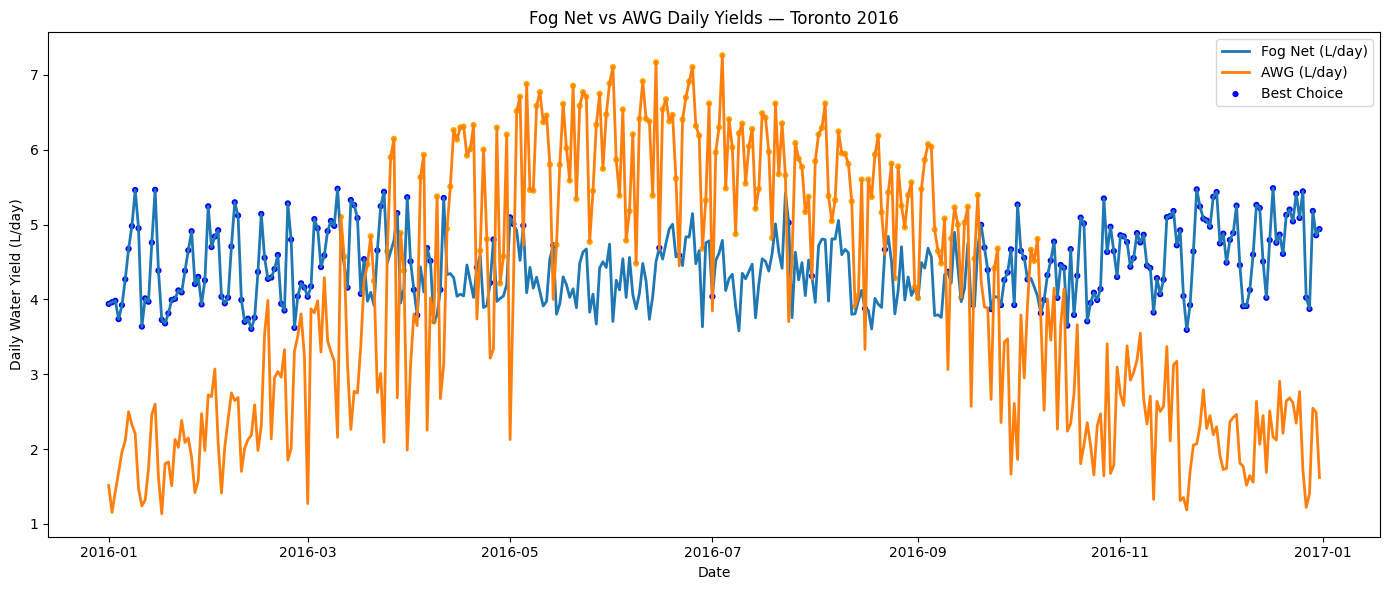

In [33]:
import matplotlib.pyplot as plt
import seaborn as sns

# Compute best yield per day explicitly
results_df["best_yield"] = np.where(
    results_df["best_choice"] == "fog_net",
    results_df["fognet_L_per_day"],
    results_df["awg_L_per_day"]
)

plt.figure(figsize=(14,6))

plt.plot(results_df["date"], results_df["fognet_L_per_day"],
         label="Fog Net (L/day)", linewidth=2)
plt.plot(results_df["date"], results_df["awg_L_per_day"],
         label="AWG (L/day)", linewidth=2)

# Scatter of best choice
plt.scatter(
    results_df["date"],
    results_df["best_yield"],
    c=np.where(results_df["best_choice"]=="fog_net", "blue", "orange"),
    s=12,
    label="Best Choice"
)

plt.xlabel("Date")
plt.ylabel("Daily Water Yield (L/day)")
plt.title("Fog Net vs AWG Daily Yields — Toronto 2016")
plt.legend()
plt.tight_layout()
plt.show()


## DEW CONDENSERS

In [34]:
# ============================================================
# DEW CONDENSER MODEL — CLEAN, CORRECT, MODULAR VERSION
# Produces: tuned_dew_model, dew_scaler, dew_feature_columns
# ============================================================

import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.neural_network import MLPRegressor
import warnings
warnings.filterwarnings("ignore")

print("=== TRAINING DEW CONDENSER MODEL ===")

# ------------------------------------------------------------
# 1) Load dataset
# ------------------------------------------------------------

df = pd.read_csv("dew_data_relationship_mapped.csv")

dew_feature_columns = ['RH_max', 'RH_avg', 'e_hPa', 'TI_C', 'WV_m_s']
dew_target_column = 'Dew_Yield_mL_m2'

X = df[dew_feature_columns].values
y = df[dew_target_column].values

# ------------------------------------------------------------
# 2) Split and scale
# ------------------------------------------------------------

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

dew_scaler = StandardScaler()
X_train_scaled = dew_scaler.fit_transform(X_train)
X_test_scaled  = dew_scaler.transform(X_test)

# ------------------------------------------------------------
# 3) Base MLP model (best performer in earlier tests)
# ------------------------------------------------------------

base_mlp = MLPRegressor(
    hidden_layer_sizes=(50, 50),
    activation='relu',
    solver='adam',
    early_stopping=True,
    max_iter=500,
    random_state=42
)

base_mlp.fit(X_train_scaled, y_train)

y_pred_base = base_mlp.predict(X_test_scaled)
print(f"Base MLP R² = {r2_score(y_test, y_pred_base):.4f}")

# ------------------------------------------------------------
# 4) Hyperparameter tuning for MLP (lightweight search)
# ------------------------------------------------------------

param_grid = {
    'hidden_layer_sizes': [(50,), (50,50), (100,50)],
    'alpha': [0.0001, 0.001],
    'activation': ['relu', 'tanh'],
    'max_iter': [400, 600]
}

grid = GridSearchCV(
    base_mlp,
    param_grid,
    scoring='r2',
    cv=5,
    n_jobs=-1
)

grid.fit(X_train_scaled, y_train)

tuned_dew_model = grid.best_estimator_

print("Best parameters:", grid.best_params_)

# ------------------------------------------------------------
# 5) Final evaluation
# ------------------------------------------------------------

y_pred = tuned_dew_model.predict(X_test_scaled)

print("=== FINAL DEW CONDENSER MODEL PERFORMANCE ===")
print(f"Train R²: {tuned_dew_model.score(X_train_scaled, y_train):.4f}")
print(f"Test  R²: {r2_score(y_test, y_pred):.4f}")
print(f"MAE (mL/m²): {mean_absolute_error(y_test, y_pred):.4f}")
print(f"RMSE (mL/m²): {np.sqrt(mean_squared_error(y_test, y_pred)):.4f}")

print("\n✓ Dew condenser model ready: tuned_dew_model")
print("✓ Dew scaler ready: dew_scaler")
print("✓ Features:", dew_feature_columns)


=== TRAINING DEW CONDENSER MODEL ===
Base MLP R² = 0.5123
Best parameters: {'activation': 'relu', 'alpha': 0.001, 'hidden_layer_sizes': (100, 50), 'max_iter': 600}
=== FINAL DEW CONDENSER MODEL PERFORMANCE ===
Train R²: 0.6840
Test  R²: 0.4827
MAE (mL/m²): 28.0755
RMSE (mL/m²): 37.5143

✓ Dew condenser model ready: tuned_dew_model
✓ Dew scaler ready: dew_scaler
✓ Features: ['RH_max', 'RH_avg', 'e_hPa', 'TI_C', 'WV_m_s']


        date  fognet_L_per_day  awg_L_per_day  dew_L_per_day best_choice  \
0 2016-01-01          3.939883       1.512980       1.950275     fog_net   
1 2016-01-02          3.961521       1.153267       1.657380     fog_net   
2 2016-01-03          3.981013       1.431492       1.811398     fog_net   
3 2016-01-04          3.736024       1.694737       1.217489     fog_net   
4 2016-01-05          3.922046       1.959615       0.715946     fog_net   

   best_yield_L_per_day  temperature_mean    rh_mean  solar_kwh  
0              3.939883         -1.540417  63.818241      1.456  
1              3.961521         -1.084167  67.620934      0.814  
2              3.981013         -1.736250  65.221794      1.280  
3              3.736024        -12.594583  55.004131      2.169  
4              3.922046         -7.869583  59.737549      2.217  


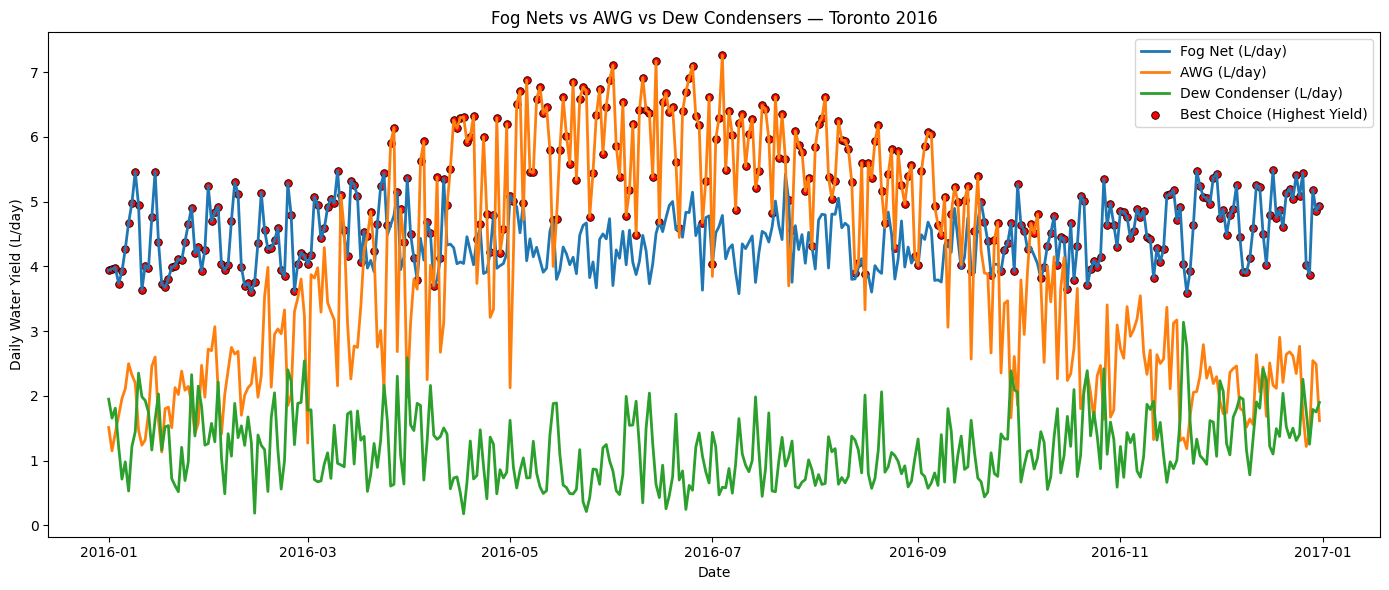

In [35]:
# ============================================================
# 0) DEW HELPERS → Build dew features for each day
# ============================================================

def compute_dew_daily_yield(day_df):
    RH_max = day_df["relative_humidity_2m"].max()
    RH_avg = day_df["relative_humidity_2m"].mean()

    dew_point = day_df["dew_point_2m"].mean()
    temp      = day_df["temperature_2m"].mean()

    # Saturation vapor pressure (Tetens)
    e_hPa = 6.112 * np.exp((17.67 * dew_point) / (dew_point + 243.5))

    TI_C = day_df["temperature_2m"].max() - day_df["temperature_2m"].min()
    WV   = day_df["wind_speed_10m"].mean()

    # Construct feature vector
    dew_vec = np.array([[RH_max, RH_avg, e_hPa, TI_C, WV]])

    # Scale with correct scaler
    dew_scaled = dew_scaler.transform(dew_vec)

    # Predict
    dew_mL_per_m2 = tuned_dew_model.predict(dew_scaled)[0]

    # Convert to L/day assuming 1 m² device
    return dew_mL_per_m2 / 1000.0




# ============================================================
# 1) FETCH TORONTO WEATHER FOR 2016  (your existing code)
# ============================================================

# ... your entire block (unchanged) ...
# toronto_2016 = ...

# ============================================================
# 2) FEATURE ENGINEERING  (unchanged)
# ============================================================

# ... your existing block ...


# ============================================================
# 3) DAILY HYBRID YIELD COMPUTATION (UPDATED FOR DEW)
# ============================================================

results = []

dates_2016 = toronto_2016["timestamp"].dt.date.unique()

for d in dates_2016:
    day_df = toronto_2016[toronto_2016["timestamp"].dt.date == d]

    if len(day_df) == 0:
        continue

    fog_y = compute_fognet_daily_yield(day_df)
    awg_y = compute_awg_daily_yield(day_df)
    dew_y = compute_dew_daily_yield(day_df)

    # Pick best of 3 systems
    values = {
        "fog_net": fog_y,
        "awg": awg_y,
        "dew": dew_y
    }
    best = max(values, key=values.get)

    results.append({
        "date": pd.to_datetime(d),

        # Yields
        "fognet_L_per_day": fog_y,
        "awg_L_per_day": awg_y,
        "dew_L_per_day": dew_y,

        "best_choice": best,
        "best_yield_L_per_day": values[best],

        # Some weather metadata
        "temperature_mean": day_df["temperature_2m"].mean(),
        "rh_mean": day_df["relative_humidity_2m"].mean(),
        "solar_kwh": day_df["shortwave_radiation"].sum()/1000
    })

results_df = pd.DataFrame(results).sort_values("date")

print(results_df.head())


# ============================================================
# 4) PLOT — Fog + AWG + Dew + Best Choice
# ============================================================

plt.figure(figsize=(14,6))

# Fog Net
plt.plot(results_df["date"], results_df["fognet_L_per_day"],
         label="Fog Net (L/day)", linewidth=2)

# AWG
plt.plot(results_df["date"], results_df["awg_L_per_day"],
         label="AWG (L/day)", linewidth=2)

# Dew Condenser
plt.plot(results_df["date"], results_df["dew_L_per_day"],
         label="Dew Condenser (L/day)", linewidth=2)

# Best choice markers — RED CIRCLES
plt.scatter(
    results_df["date"],
    results_df["best_yield_L_per_day"],
    c="red",
    s=30,
    marker="o",
    edgecolors="black",
    linewidths=0.6,
    label="Best Choice (Highest Yield)"
)

plt.xlabel("Date")
plt.ylabel("Daily Water Yield (L/day)")
plt.title("Fog Nets vs AWG vs Dew Condensers — Toronto 2016")
plt.legend()
plt.tight_layout()
plt.show()


# FUTURE PREDICTION

In [36]:
!pip install shap --quiet

Fetching 16-day forecast for Toronto...
=== 16-DAY WATER HARVESTING FORECAST ===


,date,Recommendation,Total Yield,Insight
0,2025-11-25,Fog Net,4.84,✅ Good conditions: **Humidity** is boosting levels. ⚠️ Limiting factor: **Low Clouds**.
1,2025-11-26,Fog Net,5.39,✅ Good conditions: **Humidity** is boosting levels. ⚠️ Limiting factor: **Low Clouds**.
2,2025-11-27,Fog Net,4.80,✅ Good conditions: **Temperature** is boosting levels. ⚠️ Limiting factor: **Low Clouds**.
3,2025-11-28,Fog Net,3.65,✅ Good conditions: **Moisture Levels** is boosting levels. ⚠️ Limiting factor: **Humidity**.
4,2025-11-29,Fog Net,3.81,✅ Good conditions: **Moisture Levels** is boosting levels. ⚠️ Limiting factor: **Humidity**.
5,2025-11-30,Fog Net,5.39,✅ Good conditions: **Humidity** is boosting levels. ⚠️ Limiting factor: **Low Clouds**.
6,2025-12-01,Fog Net,4.40,✅ Good conditions: **Temperature** is boosting levels. ⚠️ Limiting factor: **Humidity**.
7,2025-12-02,Fog Net,3.59,✅ Good conditions: **Sunshine** is boosting levels. ⚠️ Limiting factor: **Humidity**.
8,2025-12-03,Fog Net,3.60,✅ Good conditions: **Sunshine** is boosting levels. ⚠️ Limiting factor: **Humidity**.
9,2025-12-04,Fog Net,3.94,✅ Good conditions: **Moisture Levels** is boosting levels. ⚠️ Limiting factor: **Humidity**.


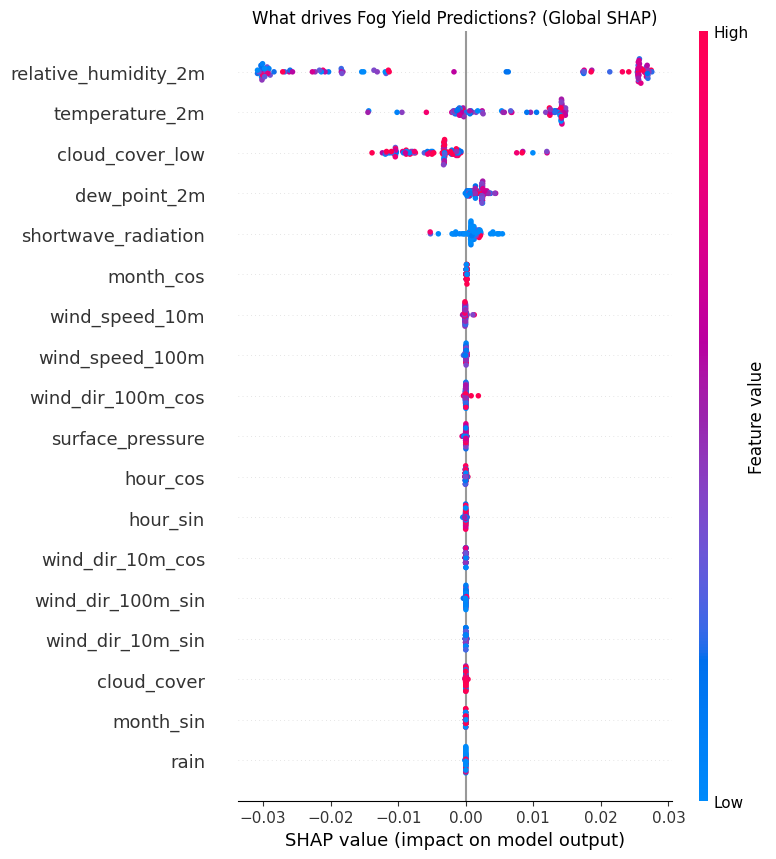

In [37]:
# 13. Future Forecasting & Interpretability (SHAP)


import shap
import pandas as pd
import numpy as np
import openmeteo_requests
import requests_cache
from retry_requests import retry

# ============================================================
# 1) FETCH 16-DAY FORECAST (TORONTO)
# ============================================================
print("Fetching 16-day forecast for Toronto...")

cache_session = requests_cache.CachedSession('.cache', expire_after = 3600)
retry_session = retry(cache_session, retries = 5, backoff_factor = 0.2)
openmeteo = openmeteo_requests.Client(session = retry_session)

url = "https://api.open-meteo.com/v1/forecast"
params = {
    "latitude": 43.7166,
    "longitude": -79.4646,
    "hourly": [
        "temperature_2m", "relative_humidity_2m", "dew_point_2m",
        "wind_speed_10m", "wind_speed_100m", "wind_direction_10m",
        "wind_direction_100m", "surface_pressure", "cloud_cover",
        "cloud_cover_low", "rain", "shortwave_radiation"
    ],
    "timezone": "America/Toronto",
    "forecast_days": 16
}

responses = openmeteo.weather_api(url, params=params)
response = responses[0]

# Process hourly data
hourly = response.Hourly()
idx_local = pd.date_range(
    start=pd.to_datetime(hourly.Time(), unit="s", utc=True),
    end=pd.to_datetime(hourly.TimeEnd(), unit="s", utc=True),
    freq=pd.Timedelta(seconds=hourly.Interval()),
    inclusive="left"
).tz_convert("America/Toronto")

# Build DataFrame
forecast_df = pd.DataFrame({
    "timestamp": idx_local,
    "temperature_2m": hourly.Variables(0).ValuesAsNumpy(),
    "relative_humidity_2m": hourly.Variables(1).ValuesAsNumpy(),
    "dew_point_2m": hourly.Variables(2).ValuesAsNumpy(),
    "wind_speed_10m": hourly.Variables(3).ValuesAsNumpy(),
    "wind_speed_100m": hourly.Variables(4).ValuesAsNumpy(),
    "wind_direction_10m": hourly.Variables(5).ValuesAsNumpy(),
    "wind_direction_100m": hourly.Variables(6).ValuesAsNumpy(),
    "surface_pressure": hourly.Variables(7).ValuesAsNumpy(),
    "cloud_cover": hourly.Variables(8).ValuesAsNumpy(),
    "cloud_cover_low": hourly.Variables(9).ValuesAsNumpy(),
    "rain": hourly.Variables(10).ValuesAsNumpy(),
    "shortwave_radiation": hourly.Variables(11).ValuesAsNumpy(),
})

# ============================================================
# 2) PREPROCESS FORECAST (Feature Engineering)
# ============================================================

def dir_to_rad(deg):
    return np.deg2rad(deg % 360)

for h in [10, 100]:
    rad = dir_to_rad(forecast_df[f"wind_direction_{h}m"])
    forecast_df[f"wind_dir_{h}m_sin"] = np.sin(rad)
    forecast_df[f"wind_dir_{h}m_cos"] = np.cos(rad)

forecast_df["hour"] = forecast_df["timestamp"].dt.hour
forecast_df["month"] = forecast_df["timestamp"].dt.month

forecast_df["hour_sin"] = np.sin(2 * np.pi * forecast_df["hour"] / 24)
forecast_df["hour_cos"] = np.cos(2 * np.pi * forecast_df["hour"] / 24)
forecast_df["month_sin"] = np.sin(2 * np.pi * forecast_df["month"] / 12)
forecast_df["month_cos"] = np.cos(2 * np.pi * forecast_df["month"] / 12)

# Features expected by the Fog Net model
features_fog = [
    "temperature_2m", "relative_humidity_2m", "dew_point_2m",
    "wind_speed_10m", "wind_speed_100m",
    "wind_dir_10m_sin", "wind_dir_10m_cos",
    "wind_dir_100m_sin", "wind_dir_100m_cos",
    "surface_pressure", "cloud_cover", "cloud_cover_low",
    "rain", "shortwave_radiation",
    "hour_sin", "hour_cos", "month_sin", "month_cos"
]

X_forecast = forecast_df[features_fog]

# ============================================================
# 3) PREDICT FUTURE YIELDS
# ============================================================

# --- A. FOG PREDICTION (Hourly) ---
# Assuming 'rf_toronto' is your trained RandomForest from previous steps
forecast_df["fog_yield_pred"] = rf_toronto.predict(X_forecast)
forecast_df["fog_yield_pred"] = forecast_df["fog_yield_pred"].clip(0, None) # No negative water

# ============================================================
# B. DAILY AGGREGATION LOOP (With Human-Friendly Insights)
# ============================================================
future_results = []
dates_future = forecast_df["timestamp"].dt.date.unique()

# Initialize SHAP Explainer
explainer = shap.TreeExplainer(rf_toronto)

# 1. Create a "Human Translator" dictionary
readable_features = {
    "temperature_2m": "Temperature",
    "relative_humidity_2m": "Humidity",
    "dew_point_2m": "Moisture Levels",
    "wind_speed_10m": "Wind Speed",
    "wind_speed_100m": "High-Altitude Wind",
    "surface_pressure": "Pressure",
    "cloud_cover": "Cloud Cover",
    "cloud_cover_low": "Low Clouds",
    "rain": "Rainfall",
    "shortwave_radiation": "Sunshine",
    "wind_dir_10m_sin": "Wind Direction",
    "wind_dir_10m_cos": "Wind Direction",
    "wind_dir_100m_sin": "Wind Direction",
    "wind_dir_100m_cos": "Wind Direction",
    "hour_sin": "Time of Day",
    "hour_cos": "Time of Day",
    "month_sin": "Seasonality",
    "month_cos": "Seasonality"
}

for d in dates_future:
    day_df = forecast_df[forecast_df["timestamp"].dt.date == d]
    if day_df.empty: continue

    # 1. Calculate Sums
    fog_sum = day_df["fog_yield_pred"].sum()
    awg_sum = compute_awg_daily_yield(day_df)
    dew_sum = compute_dew_daily_yield(day_df)

    # 2. Pick Winner
    yields = {"Fog Net": fog_sum, "AWG": awg_sum, "Dew Condenser": dew_sum}
    best_tech = max(yields, key=yields.get)
    best_val = yields[best_tech]

    # 3. Generate Friendly Insight
    insight_text = ""

    if best_tech == "Fog Net":
        if fog_sum < 1.0:
            insight_text = "Conditions are poor for all systems. Fog is the best of a bad bunch."
        else:
            # SHAP Analysis for Fog
            X_day = day_df[features_fog]
            shap_values = explainer.shap_values(X_day)
            mean_shap = np.mean(shap_values, axis=0)

            # Find top positive (driver) and negative (barrier) features
            feature_impact = pd.DataFrame({
                "feature": features_fog,
                "impact": mean_shap
            }).sort_values("impact", ascending=False)

            top_driver_raw = feature_impact.iloc[0]['feature']
            top_barrier_raw = feature_impact.iloc[-1]['feature']
            barrier_score = feature_impact.iloc[-1]['impact']

            # Translate names
            driver_name = readable_features.get(top_driver_raw, top_driver_raw)
            barrier_name = readable_features.get(top_barrier_raw, top_barrier_raw)

            insight_text = f"✅ Good conditions: **{driver_name}** is boosting levels."

            # Only mention the barrier if it's actually hurting (negative impact)
            if barrier_score < 0:
                insight_text += f" ⚠️ Limiting factor: **{barrier_name}**."

    elif best_tech == "AWG":
        # Check if it's a "Good" AWG day (>3L) or just better than nothing
        if awg_sum > 3.0:
            insight_text = "☀️ **High Solar Energy** detected. The active generator is running at peak efficiency."
        else:
            insight_text = "Standard operation. Solar levels are sufficient to outperform passive nets."

    elif best_tech == "Dew Condenser":
        insight_text = "🌌 **Clear Skies & Calm Winds**. Radiative cooling is active, making Dew the best choice tonight."

    future_results.append({
        "date": d,
        "Fog (L)": round(fog_sum, 2),
        "AWG (L)": round(awg_sum, 2),
        "Dew (L)": round(dew_sum, 2),
        "Recommendation": best_tech,
        "Total Yield": round(best_val, 2),
        "Insight": insight_text
    })

future_df = pd.DataFrame(future_results)

# Display Forecast Table with improved text
print("=== 16-DAY WATER HARVESTING FORECAST ===")
pd.set_option('display.max_colwidth', None) # Make sure we can read the full text
display(future_df[["date", "Recommendation", "Total Yield", "Insight"]].head(10))
# ============================================================
# 4) VISUALIZE SHAP (Global Explanation)
# ============================================================
# This plot shows generally what the model looks for
plt.figure(figsize=(10, 6))
plt.title("What drives Fog Yield Predictions? (Global SHAP)")
shap_values_global = explainer.shap_values(X_forecast.sample(100)) # Sample for speed
shap.summary_plot(shap_values_global, X_forecast.sample(100), show=False)
plt.tight_layout()
plt.show()


=== GENERATING LONG-TERM 2026 PROJECTION ===
Fetching 10 years of historical data to build a 'Typical Meteorological Year'...


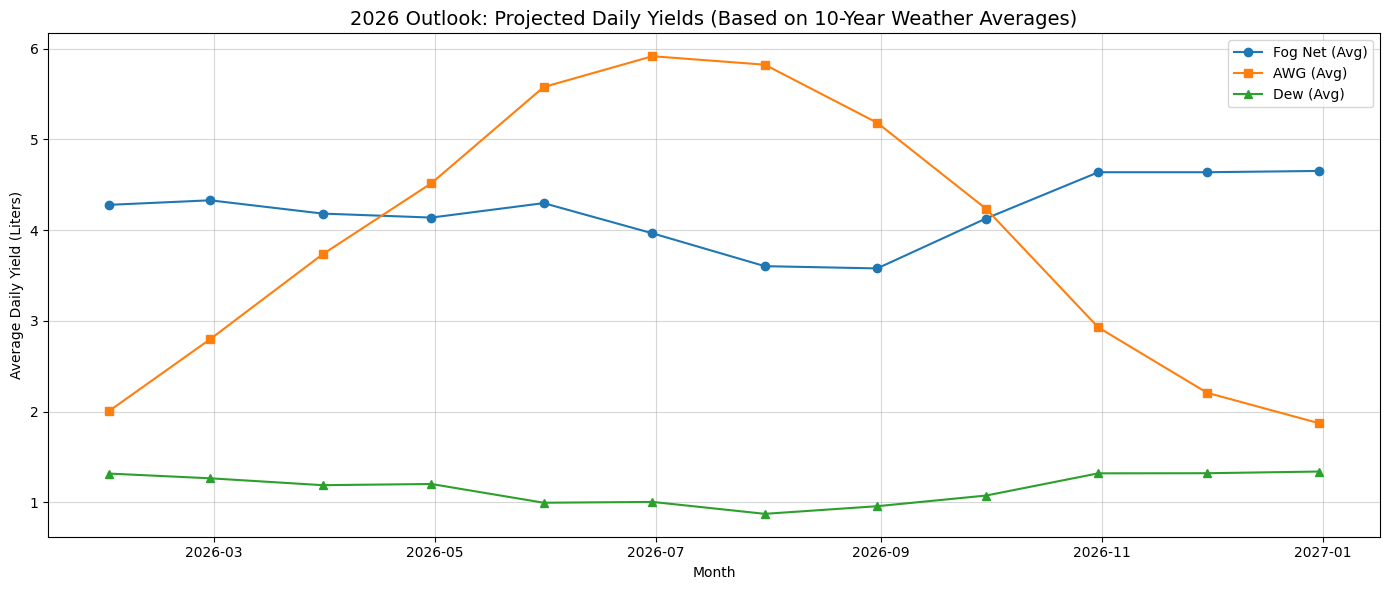

✓ Long-term simulation complete.
Projected Total Water Harvesting for 2026: 1,775 Liters


In [38]:
# ============================================================
# 2. LONG-TERM OUTLOOK (Simulating 2026 via Historical Averages)
# ============================================================
print("\n=== GENERATING LONG-TERM 2026 PROJECTION ===")
print("Fetching 10 years of historical data to build a 'Typical Meteorological Year'...")

# --- Step A: Fetch 10 Years of History (2010-2020) ---
url_hist = "https://archive-api.open-meteo.com/v1/archive"
params_hist = {
    "latitude": 43.7166,
    "longitude": -79.4646,
    "start_date": "2010-01-01",
    "end_date": "2020-12-31",
    "hourly": [
        "temperature_2m", "relative_humidity_2m", "dew_point_2m",
        "wind_speed_10m", "wind_speed_100m", "wind_direction_10m",
        "wind_direction_100m", "surface_pressure", "cloud_cover",
        "cloud_cover_low", "rain", "shortwave_radiation"
    ],
    "timezone": "America/Toronto"
}

responses_hist = openmeteo.weather_api(url_hist, params=params_hist)
hist_hourly = responses_hist[0].Hourly()

idx_hist = pd.date_range(
    start=pd.to_datetime(hist_hourly.Time(), unit="s", utc=True),
    end=pd.to_datetime(hist_hourly.TimeEnd(), unit="s", utc=True),
    freq=pd.Timedelta(seconds=hist_hourly.Interval()),
    inclusive="left"
).tz_convert("America/Toronto")

hist_df = pd.DataFrame({
    "timestamp": idx_hist,
    "temperature_2m": hist_hourly.Variables(0).ValuesAsNumpy(),
    "relative_humidity_2m": hist_hourly.Variables(1).ValuesAsNumpy(),
    "dew_point_2m": hist_hourly.Variables(2).ValuesAsNumpy(),
    "wind_speed_10m": hist_hourly.Variables(3).ValuesAsNumpy(),
    "wind_speed_100m": hist_hourly.Variables(4).ValuesAsNumpy(),
    "wind_direction_10m": hist_hourly.Variables(5).ValuesAsNumpy(),
    "wind_direction_100m": hist_hourly.Variables(6).ValuesAsNumpy(),
    "surface_pressure": hist_hourly.Variables(7).ValuesAsNumpy(),
    "cloud_cover": hist_hourly.Variables(8).ValuesAsNumpy(),
    "cloud_cover_low": hist_hourly.Variables(9).ValuesAsNumpy(),
    "rain": hist_hourly.Variables(10).ValuesAsNumpy(),
    "shortwave_radiation": hist_hourly.Variables(11).ValuesAsNumpy(),
})

# --- Step B: Create "Average Weather" for 2026 ---
hist_df["month"] = hist_df["timestamp"].dt.month
hist_df["day"]   = hist_df["timestamp"].dt.day
hist_df["hour"]  = hist_df["timestamp"].dt.hour

# FIXED: Explicitly select numeric columns to average (excluding timestamp)
cols_to_avg = [
    "temperature_2m", "relative_humidity_2m", "dew_point_2m",
    "wind_speed_10m", "wind_speed_100m", "wind_direction_10m",
    "wind_direction_100m", "surface_pressure", "cloud_cover",
    "cloud_cover_low", "rain", "shortwave_radiation"
]

# Calculate mean only on specific columns
typical_weather = hist_df.groupby(["month", "day", "hour"])[cols_to_avg].mean().reset_index()

# Generate 2026 Timestamps
dates_2026 = pd.date_range(start="2026-01-01", end="2026-12-31", freq="H", tz="America/Toronto")
future_2026 = pd.DataFrame({"timestamp": dates_2026})
future_2026["month"] = future_2026["timestamp"].dt.month
future_2026["day"]   = future_2026["timestamp"].dt.day
future_2026["hour"]  = future_2026["timestamp"].dt.hour

# Merge Average Weather onto 2026 dates
sim_2026 = pd.merge(future_2026, typical_weather, on=["month", "day", "hour"], how="left").ffill()

# --- Step C: Feature Engineering for 2026 ---
for h in [10, 100]:
    rad = dir_to_rad(sim_2026[f"wind_direction_{h}m"])
    sim_2026[f"wind_dir_{h}m_sin"] = np.sin(rad)
    sim_2026[f"wind_dir_{h}m_cos"] = np.cos(rad)

sim_2026["hour_sin"] = np.sin(2 * np.pi * sim_2026["hour"] / 24)
sim_2026["hour_cos"] = np.cos(2 * np.pi * sim_2026["hour"] / 24)
sim_2026["month_sin"] = np.sin(2 * np.pi * sim_2026["month"] / 12)
sim_2026["month_cos"] = np.cos(2 * np.pi * sim_2026["month"] / 12)

# --- Step D: Run Models for 2026 ---
# 1. Fog
X_2026 = sim_2026[features_fog]
sim_2026["fog_yield_pred"] = rf_toronto.predict(X_2026).clip(0, None)

# 2. Daily Aggregation
proj_results = []
for d in sim_2026["timestamp"].dt.date.unique():
    day_data = sim_2026[sim_2026["timestamp"].dt.date == d]

    fog_tot = day_data["fog_yield_pred"].sum()
    awg_tot = compute_awg_daily_yield(day_data)
    dew_tot = compute_dew_daily_yield(day_data)

    best = max(fog_tot, awg_tot, dew_tot)

    proj_results.append({
        "date": d,
        "Fog (L)": fog_tot,
        "AWG (L)": awg_tot,
        "Dew (L)": dew_tot,
        "Best Yield (L)": best
    })

proj_df = pd.DataFrame(proj_results)
proj_df["date"] = pd.to_datetime(proj_df["date"])

# --- Step E: Visualizing the Long Term Outlook ---
plt.figure(figsize=(14, 6))

# Plot simplified monthly averages
proj_monthly = proj_df.set_index("date").resample("M").mean()

plt.plot(proj_monthly.index, proj_monthly["Fog (L)"], label="Fog Net (Avg)", marker="o")
plt.plot(proj_monthly.index, proj_monthly["AWG (L)"], label="AWG (Avg)", marker="s")
plt.plot(proj_monthly.index, proj_monthly["Dew (L)"], label="Dew (Avg)", marker="^")

plt.title("2026 Outlook: Projected Daily Yields (Based on 10-Year Weather Averages)", fontsize=14)
plt.ylabel("Average Daily Yield (Liters)")
plt.xlabel("Month")
plt.grid(True, alpha=0.5)
plt.legend()
plt.tight_layout()
plt.show()

print("✓ Long-term simulation complete.")
print(f"Projected Total Water Harvesting for 2026: {proj_df['Best Yield (L)'].sum():,.0f} Liters")

In [39]:
import joblib

# 1. Save the California-to-Toronto Fog Model
joblib.dump(rf_toronto, 'fog_model.joblib')

# 2. Save the Dew Condenser Model
joblib.dump(tuned_dew_model, 'dew_model.joblib')

# 3. Save the Dew Scaler (Critical! You need this to normalize inputs)
joblib.dump(dew_scaler, 'dew_scaler.joblib')

print("✅ Models saved! Download these 3 .joblib files.")

✅ Models saved! Download these 3 .joblib files.
